In [1]:
from utils.basics import RESOURCES_NIMARE_DIR, ATLASES_DIR, FB_400ROI_ATLAS_NAME, RESOURCES_CONN_DIR
from utils.plotting import create_graph_from_matrix
import os
import os.path as osp
from nimare.extract import fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
import nibabel as nib
from nilearn.image import load_img
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn import masking
import numpy as np
import pandas as pd
from utils.basics import FB_400ROI_ATLAS_PATH
import subprocess
from nimare.decode import discrete
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import panel as pn
import matplotlib.pyplot as plt

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


SystemError: initialization of _internal failed without raising an exception

In [ ]:
import wordcloud
print(wordcloud.__version__)

In [ ]:
def my_orange_color_func(dictionary):
    def my_orange_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        freq_as_int = int(dictionary[word])
        color_list = sns.color_palette('Oranges',100).as_hex()
        return color_list[freq_as_int]
    return my_orange_color_func_inner
def my_blue_color_func(dictionary):
    def my_blue_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        freq_as_int = int(dictionary[word])
        color_list = sns.color_palette('Blues',100).as_hex()
        return color_list[freq_as_int]
    return my_blue_color_func_inner

# 1. NiMare Setup
## 1.1. Folder Setup

In [ ]:
vocab = 'LDA50' #Was 'LDA50'
ATLAS_NAME = FB_400ROI_ATLAS_NAME

In [ ]:
VOCAB_DIR            = osp.join(RESOURCES_NIMARE_DIR,vocab)
METAMAPS_ORIG_DIR    = osp.join(VOCAB_DIR,"meta-analyses-orig")  # where to save meta-analysis maps
METAMAPS_RPI_DIR     = osp.join(VOCAB_DIR,"meta-analyses-RPI")  # where to save meta-analysis maps

ns_dset_path         = osp.join(VOCAB_DIR, f"neurosynth_dataset_{vocab}.pkl.gz")
ns_dset_mask_path    = osp.join(VOCAB_DIR, f"neurosynth_dataset_{vocab}_mask.nii")
#lda_model_path       = osp.join(VOCAB_DIR, f'lda_model.pkl.gz')

print('++ INFO: Resource Folder for NiMare Analyses                              : %s' % RESOURCES_NIMARE_DIR)
print('++ INFO: Folder for this vocabulary                                       : %s' % VOCAB_DIR)
print('++ INFO: Folder for meta-maps in original orientation as written by NiMare: %s' % METAMAPS_ORIG_DIR)
print('++ INFO: Folder for meta-maps in RPI orientation (the one our data has)   : %s' % METAMAPS_RPI_DIR)
print('++ ------------------------------------------------------------------------')
print('++ INFO: Path for NeuroSynth Dataset in NiMare format                     : %s' % ns_dset_path)
print('++ INFO: Path for NeuroSynth Dataset mask                                 : %s' % ns_dset_mask_path)
#print('++ INFO: Path for locally trained LDA model.                              : %s' % lda_model_path)

In [6]:
# Create Empty Output Folders
# ===========================
print("++ INFO: Setting up all necessary folders")
for folder_path in [VOCAB_DIR, METAMAPS_ORIG_DIR, METAMAPS_RPI_DIR]:
    if osp.exists(folder_path):
        print(" + WARNING: Removing folder [%s]" % folder_path)
        shutil.rmtree(folder_path)
    print(" + INFO: Generating/Regenerating output folder [%s]" % folder_path)
    os.mkdir(folder_path)

++ INFO: Setting up all necessary folders
 + WARNING: Removing folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-orig]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI]


## 1.2. Download Neurosynth 7 database

First, we need to download the Neurosynth database (version 7) for the 400 Topic Vocabulary

In [7]:
# Download NeuroSynth database
print("++ INFO: Fetching neurosynth dataset for this vocabulary...")
files = fetch_neurosynth(data_dir=VOCAB_DIR, version="7", overwrite=False, vocab=vocab, source="abstract")

INFO:nimare.extract.utils:Dataset created in /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth
INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('vocab-LDA50', 'source-abstract', 'data-neurosynth', 'version-7')]


++ INFO: Fetching neurosynth dataset for this vocabulary...


## 1.3. Convert Neurosynth Database to NiMare Dataset

Next, we need to convert it into a format NiMare can understand

In [8]:
%%time
# Convert to NiMare Dataset
neurosynth_db = files[0]
neurosynth_dset = convert_neurosynth_to_dataset(
        coordinates_file=neurosynth_db['coordinates'],
        metadata_file=neurosynth_db['metadata'],
        annotations_files=neurosynth_db['features'],
        )

CPU times: user 2min 51s, sys: 1.07 s, total: 2min 52s
Wall time: 2min 46s


To avoid having to do these two steps continously, we will save the NiMare version of the NeuroSynth Database to disk. If we need it again, we just have to load this file.

In [9]:
%%time
# Save the dataset as a pickle file to the Resources directory
print ("++ INFO: Saving NeuroSynth Dataset to disk: %s" % ns_dset_path)
neurosynth_dset.save(ns_dset_path)

++ INFO: Saving NeuroSynth Dataset to disk: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50.pkl.gz
CPU times: user 13.7 s, sys: 21.9 ms, total: 13.7 s
Wall time: 13.7 s


As a sanity check, we print the labels for the first 10 topics and count how many topics in total are in the database.

In [10]:
# Extract Topic Names
topics_ORIG = neurosynth_dset.get_labels()
print('++ INFO: First few topics      : %s' % str(topics_ORIG[0:10]))
print('++ INFO: Total number of topics: %d' % len(topics_ORIG))

++ INFO: First few topics      : ['LDA50_abstract_weight__0_network_state_resting', 'LDA50_abstract_weight__1_anxiety_trait_personality', 'LDA50_abstract_weight__2_cerebellar_cerebellum_basal', 'LDA50_abstract_weight__3_cortex_anterior_cingulate', 'LDA50_abstract_weight__4_stimulus_time_repetition', 'LDA50_abstract_weight__5_gyrus_frontal_inferior', 'LDA50_abstract_weight__6_auditory_speech_temporal', 'LDA50_abstract_weight__7_reward_feedback_striatum', 'LDA50_abstract_weight__8_mpfc_social_medial', 'LDA50_abstract_weight__9_memory_working_wm']
++ INFO: Total number of topics: 50


## 1.4. Extract Dset Mask

This is necessary to ensure that any dataset that we decode is sitting on the same space and grid that NiMare expects

In [11]:
nib.save(neurosynth_dset.masker.mask_img,ns_dset_mask_path)
print('++ INFO: Neurosynth Dataset mask saved to disk: %s' % ns_dset_mask_path)

++ INFO: Neurosynth Dataset mask saved to disk: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50_mask.nii


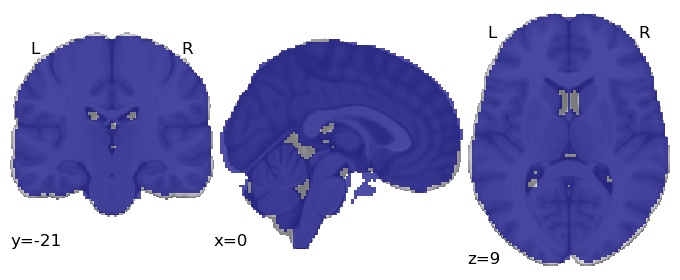

In [12]:
dset_mask = load_img(ns_dset_mask_path)
plot_roi(dset_mask, draw_cross=False)

## 1.5 Make a version of the Atlas that has the same space and grid than the NeuroSynth Dataset

In [13]:
FB_400ROI_ATLAS_ORIG_GRID_FILE   = osp.join(FB_400ROI_ATLAS_PATH,f'{ATLAS_NAME}.nii.gz')
FB_400ROI_ATLAS_NIMARE_GRID_FILE = osp.join(RESOURCES_NIMARE_DIR,f'{ATLAS_NAME}_NiMareGrid.nii.gz')
command = f'''module load afni; \
              3dresample -overwrite -rmode NN \
                         -input  {FB_400ROI_ATLAS_ORIG_GRID_FILE} \
                         -prefix {FB_400ROI_ATLAS_NIMARE_GRID_FILE} \
                         -master {ns_dset_mask_path}'''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2023-08-25


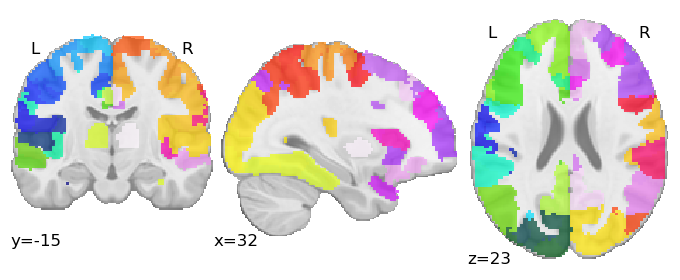

In [14]:
atlas_img = load_img(FB_400ROI_ATLAS_NIMARE_GRID_FILE)
plot_roi(atlas_img, draw_cross=False)

# 2. Extract ROIs with highest degree for both NBS contrasts

# 2.1. Load Atlas Information so that we can annotate Pandas Dataframes

In [15]:
ATLASINFO_PATH = osp.join(ATLASES_DIR,ATLAS_NAME,'{ATLAS_NAME}.roi_info.csv'.format(ATLAS_NAME=ATLAS_NAME))
roi_info       = pd.read_csv(ATLASINFO_PATH)

## 2.2. Load NBS Results

In [16]:
BEHAVIOR_LIST        = ['Factor1','Factor2','Vigilance','Images','Surroundings','Past'] # Load only those that were significant
CPM_models = {}

In [17]:
%%time
for BEHAVIOR in tqdm(BEHAVIOR_LIST, desc='Behaviors'):
    aux_model = np.loadtxt(osp.join(RESOURCES_CONN_DIR,f'CPM_{BEHAVIOR}_matrix.txt'))
    
    CPM_models[(BEHAVIOR,'glm')] = pd.DataFrame(abs(aux_model),
                                        index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                                        columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index).astype(int)
    CPM_models[(BEHAVIOR,'pos')] = pd.DataFrame(aux_model>0,
                                        index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                                        columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index).astype(int)
    CPM_models[(BEHAVIOR,'neg')] = pd.DataFrame(aux_model<0,
                                        index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                                        columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index).astype(int)
    
    del aux_model

Behaviors: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 18.03it/s]


CPU times: user 199 ms, sys: 13.9 ms, total: 213 ms
Wall time: 336 ms


## 2.3. Create Graph Models needed to compute Degree

In [18]:
%%time
CPM_Gs,CPM_Gatts = {},{}
for model in CPM_models.keys():
    print(model, CPM_models[model].sum().sum(), end=' | ')
    # Create Graph Model
    CPM_Gs[model],CPM_Gatts[model]      = create_graph_from_matrix(CPM_models[model])
    CPM_Gatts[model] =  CPM_Gatts[model].set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).sort_index(level='ROI_ID')
N_rois = CPM_Gatts[model].shape[0]
print('\n\n++ INFO: Number of ROIs: %d' % N_rois)

('Factor1', 'glm') 1996 | ('Factor1', 'pos') 318 | ('Factor1', 'neg') 1678 | ('Factor2', 'glm') 3452 | ('Factor2', 'pos') 2494 | ('Factor2', 'neg') 958 | ('Vigilance', 'glm') 7514 | ('Vigilance', 'pos') 3978 | ('Vigilance', 'neg') 3536 | ('Images', 'glm') 1686 | ('Images', 'pos') 558 | ('Images', 'neg') 1128 | ('Surroundings', 'glm') 2226 | ('Surroundings', 'pos') 1826 | ('Surroundings', 'neg') 400 | ('Past', 'glm') 1838 | ('Past', 'pos') 1598 | ('Past', 'neg') 240 | 

++ INFO: Number of ROIs: 380
CPU times: user 1.94 s, sys: 17.9 ms, total: 1.95 s
Wall time: 1.95 s


## 2.4. Write Graph Metric-per-ROI Results to disk as NifTi Files

We load the atlas (the version on the grid that aligns with NiMare) as a vector.

In [19]:
atlas_vector = masking.apply_mask(FB_400ROI_ATLAS_NIMARE_GRID_FILE, dset_mask)
print('++ INFO: Atlas Dimensions as a vector = %s' % str(atlas_vector.shape))

++ INFO: Atlas Dimensions as a vector = (228483,)


++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-glm_Degree.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-glm_Eigenvector_Centrality.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-glm_Page_Rank.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-pos_Degree.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-pos_Eigenvector_Centrality.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-pos_Page_Rank.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor

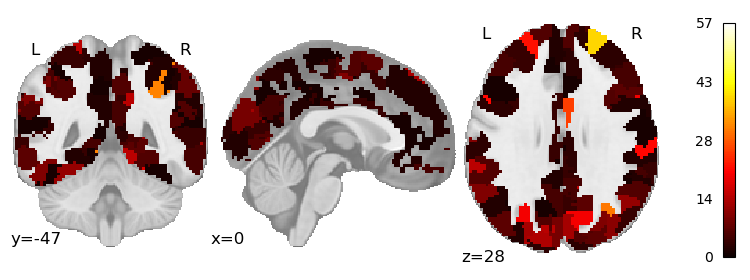

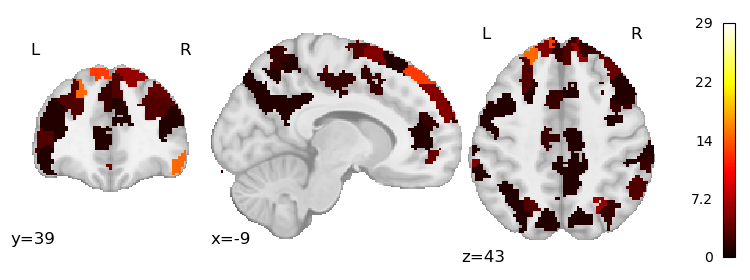

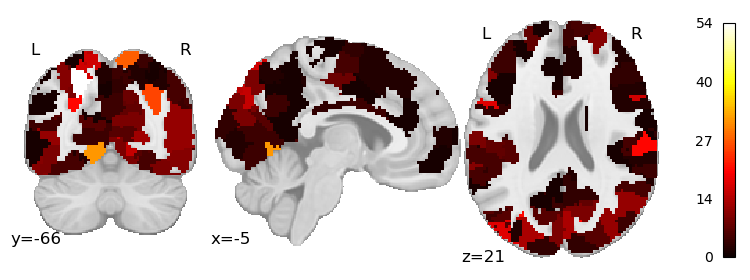

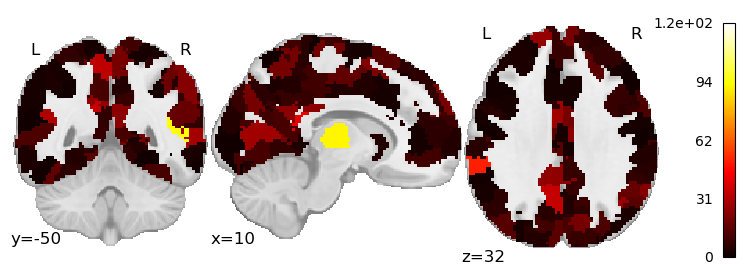

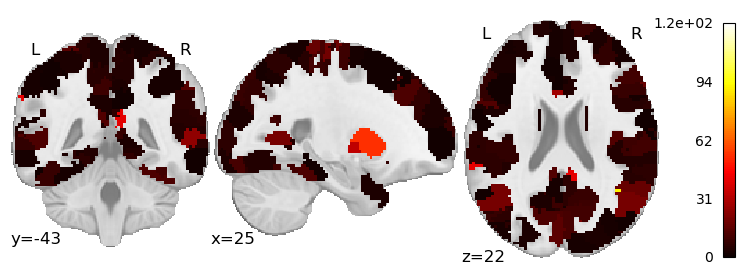

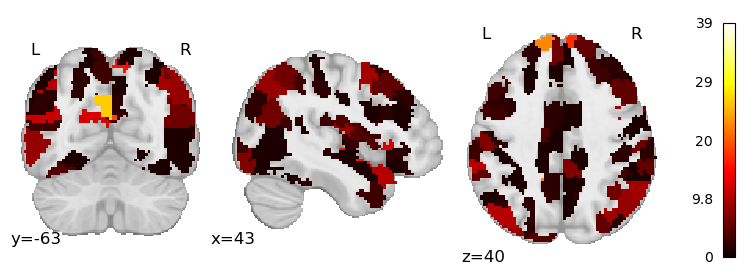

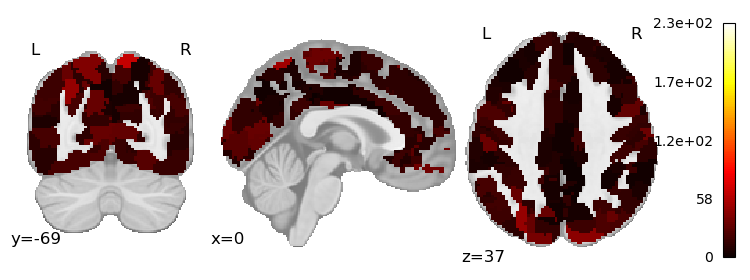

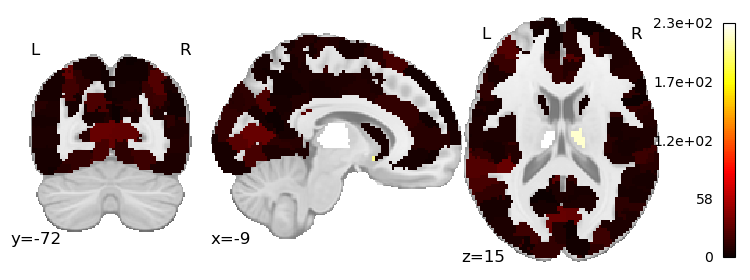

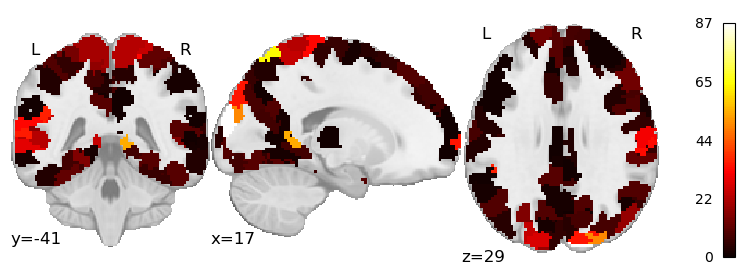

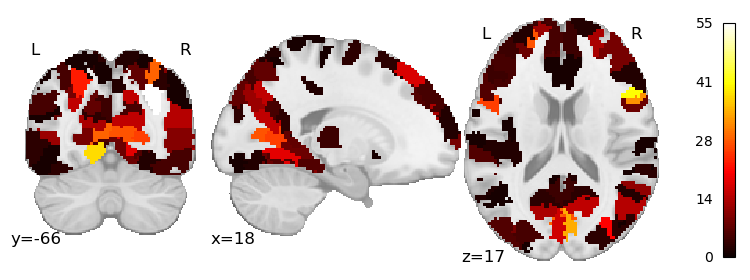

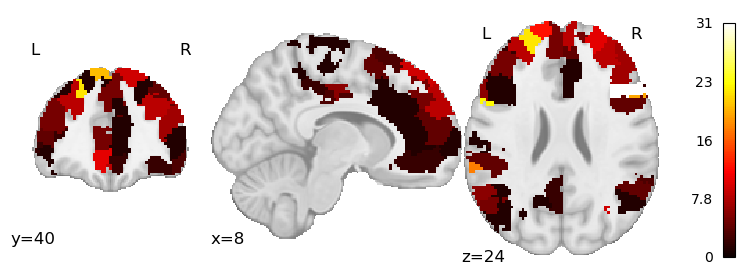

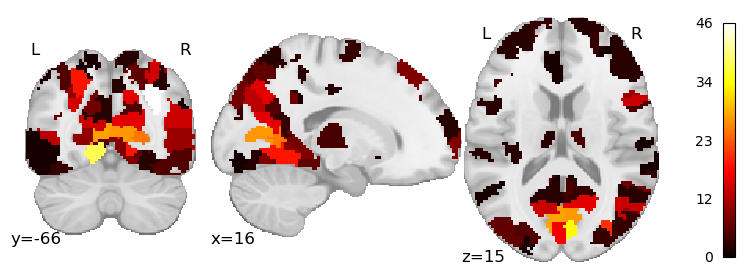

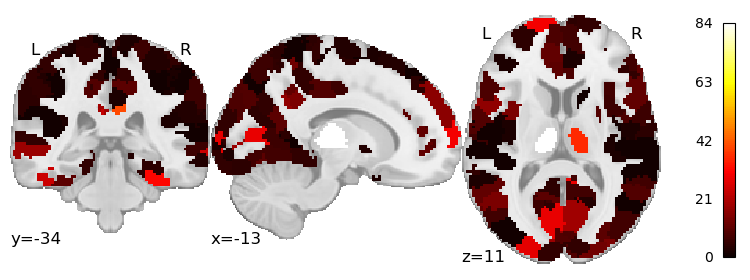

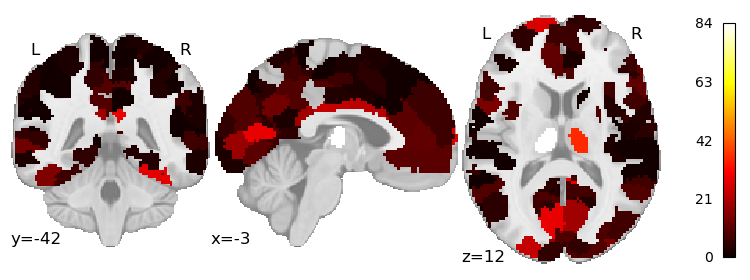

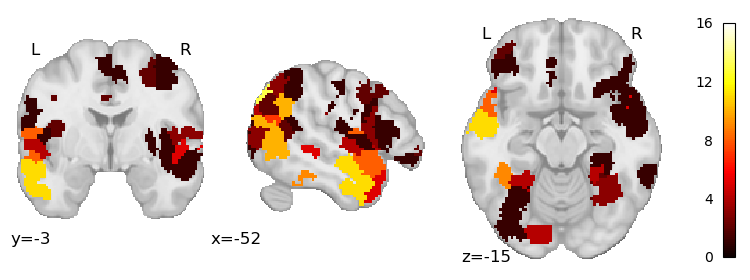

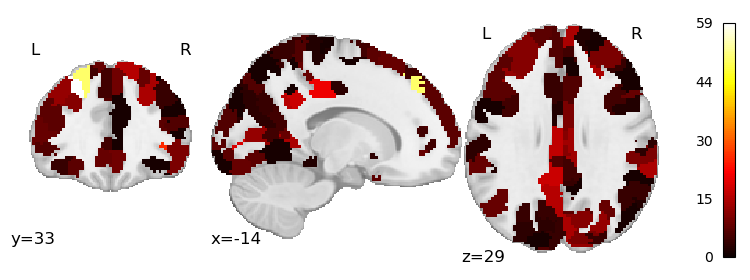

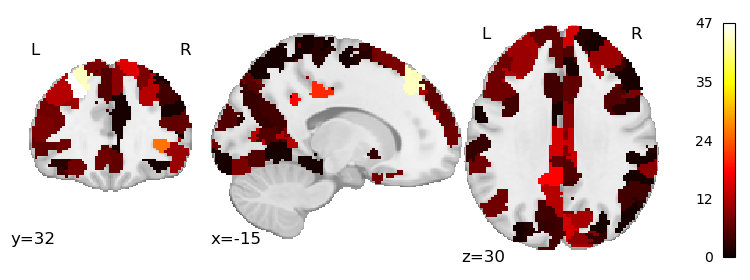

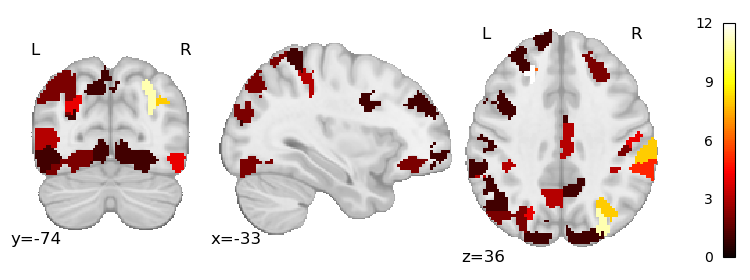

In [20]:
%%time
for model in CPM_models.keys():
    file_suffix = '-'.join(model)
    for metric in ['Degree','Eigenvector_Centrality','Page_Rank']:
        # Create Empty Vector with same dimensions as atlas
        output_vector = np.zeros(atlas_vector.shape)
        # For each ROI extract the Graph Metric of interest
        for hm,nw,roi_name,roi_id,rgb in CPM_Gatts[model].index:
            output_vector[atlas_vector==roi_id] = CPM_Gatts[model].loc[(hm,nw,roi_name,roi_id,rgb),metric]
        # Write to disk just in case we want to look at it later
        output_img = masking.unmask(output_vector,dset_mask)
        output_path = osp.join(RESOURCES_NIMARE_DIR,f'{file_suffix}_{metric}.nii')
        output_img.to_filename(output_path)
        print('++ INFO: File written to disk [%s]' % output_path)
        if metric == 'Degree':
            plot_stat_map(output_path, draw_cross=False)

## 2.5. Also write file for the top degree ROI for each contrast (this is the one we will decode)

In [25]:
for model in CPM_models.keys():
    file_suffix = '-'.join(model)
    input_path = osp.join(RESOURCES_NIMARE_DIR,f'{file_suffix}_Degree.nii')
    input_img  = load_img(input_path)
    #top_degree_value = int(input_img.get_fdata().max())
    a = input_img.get_fdata()
    a = np.array(a.flatten())
    a = pd.Series(np.unique(a).astype(int))
    top5_degree_values = a.sort_values(ascending=False).values[0:5]
    for i,dv in enumerate(top5_degree_values):
        output_path = osp.join(RESOURCES_NIMARE_DIR,f'{file_suffix}_Degree_Top{i}_ROI.nii')
        command = f'''module load afni; \
                  3dcalc -overwrite -a {input_path} -expr "equals(a,{dv})" -prefix {output_path}'''
        output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2023-08-24

++ 3dcalc: AFNI version=AFNI_23.2.08 (Aug 22 2023) [64-bit]
++ Authored by: A cast of thousands
** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-glm_Degree.nii to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ Output dataset /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-glm_Degree_Top0_ROI.nii
[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2023-08-24

++ 3dcalc: AFNI version=AFNI_23.2.08 (Aug 22 2023) [64-bit]
++ Authored by: A cast of thousands
** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-glm_Degree.nii to FLOAT32
     Warnings of t

# 3. Preparations for WordCloud & ROI plot generation

Neurosynth topics and terms contain words that are not necessarily that meaningful when looking for relationships to cognitive processes. Examples of such words include those about anatomical structures, anatomical location, tissue types, imaging modalities, etc. We will remove those prior to generating wordclouds

In [20]:
my_stopwords = list(STOPWORDS) + ['resonance','magnetic','medial','lateral','dorsal','ventral','anterior','posterior','primary','secondary',
                                  'contralateral','prefrontal','temporal','occipital','parietal','frontal','network','cortex',
                                  'sii','mns','neuron','pre','md','gm','volume','matter','white','gray','hemispheric','state','mpfc','dmn','default',
                                  'fc','rest', 'temporoparietal','hippocampus','insula','premotor','supplementary','resting','gyrus','sulcus','task','tasks','trial','trials','rt']

In this study we work with the 50 Topic dictionary. Each topic is associated with a set of terms that appear in unison in the neuroimaing literature. The next cell gathers the 40 top terms associated with each topic. We will only pick only those assoicated with topics that show significant correlations with our ROIs later when generating wordclouds. For now we load them all and have then ready on a pandas dataframe.

In [21]:
if vocab != 'terms':
    path            = osp.join(VOCAB_DIR,'neurosynth',f'data-neurosynth_version-7_vocab-{vocab}_keys.tsv')
    words_per_topic = pd.read_csv(path, sep='\t', header=None)
    words_per_topic.index = neurosynth_dset.get_labels()
    words_per_topic.index.name = 'Topic Label'
    words_per_topic.columns = ['Topic ID','Unknown','Terms']
    words_per_topic.head(5)

Finally, we will want to show the ROI with the highest degree for a given model. To make nilearn plot the countour in black color, we need to generate a fake colormap with black being the first color.

If we are not dealing with terms directly, which is the case with the topic dictionaries, we need to first create a dictionary with the invidual terms assoicated with each topic.

That dictorionary will contain the term, and a weight that corresponds to the inverse rank of the term within the topic. As we consider only the top 40 terms associated with each topic (what Neurosynth makes available), weights will be integers in the range 1 to 40.

In [22]:
if vocab != 'terms':
    term_weights_per_topic={}
    for topic in words_per_topic.index:
        this_topic_words              = words_per_topic.loc[topic]['Terms']
        this_topic_words_top40        = this_topic_words.split(' ')[0:40][::-1]
        term_weights_per_topic[topic] = {word:weight+1 for weight,word in enumerate(this_topic_words_top40)}

In [23]:
roi_cmap = LinearSegmentedColormap.from_list('black',['#000000','#ffffff'],10)

# 4. ROI decoding on location with highest degree

## 4.1. NBS - Factor 1
### 4.1.1. Show areas with highest degree

In [24]:
top_degree_list_F1_pos = CPM_Gatts['Factor1','pos'].drop(['Degree_Centrality','Eigenvector_Centrality','Page_Rank'],axis=1).copy()
top_degree_list_F1_pos.index = top_degree_list_F1_pos.index.droplevel(['RGB','ROI_ID','Network','Hemisphere'])
top_degree_list_F1_pos.index.name = 'Factor1 - Positive'
top_degree_list_F1_neg = CPM_Gatts['Factor1','neg'].drop(['Degree_Centrality','Eigenvector_Centrality','Page_Rank'],axis=1).copy()
top_degree_list_F1_neg.index = top_degree_list_F1_neg.index.droplevel(['RGB','ROI_ID','Network','Hemisphere'])
top_degree_list_F1_neg.index.name = 'Factor1 - Negative'
pn.Row(top_degree_list_F1_pos.sort_values(by='Degree', ascending=False).head(5),top_degree_list_F1_neg.sort_values(by='Degree', ascending=False).head(5))

Row
    [0] DataFrame(DataFrame)
    [1] DataFrame(DataFrame)

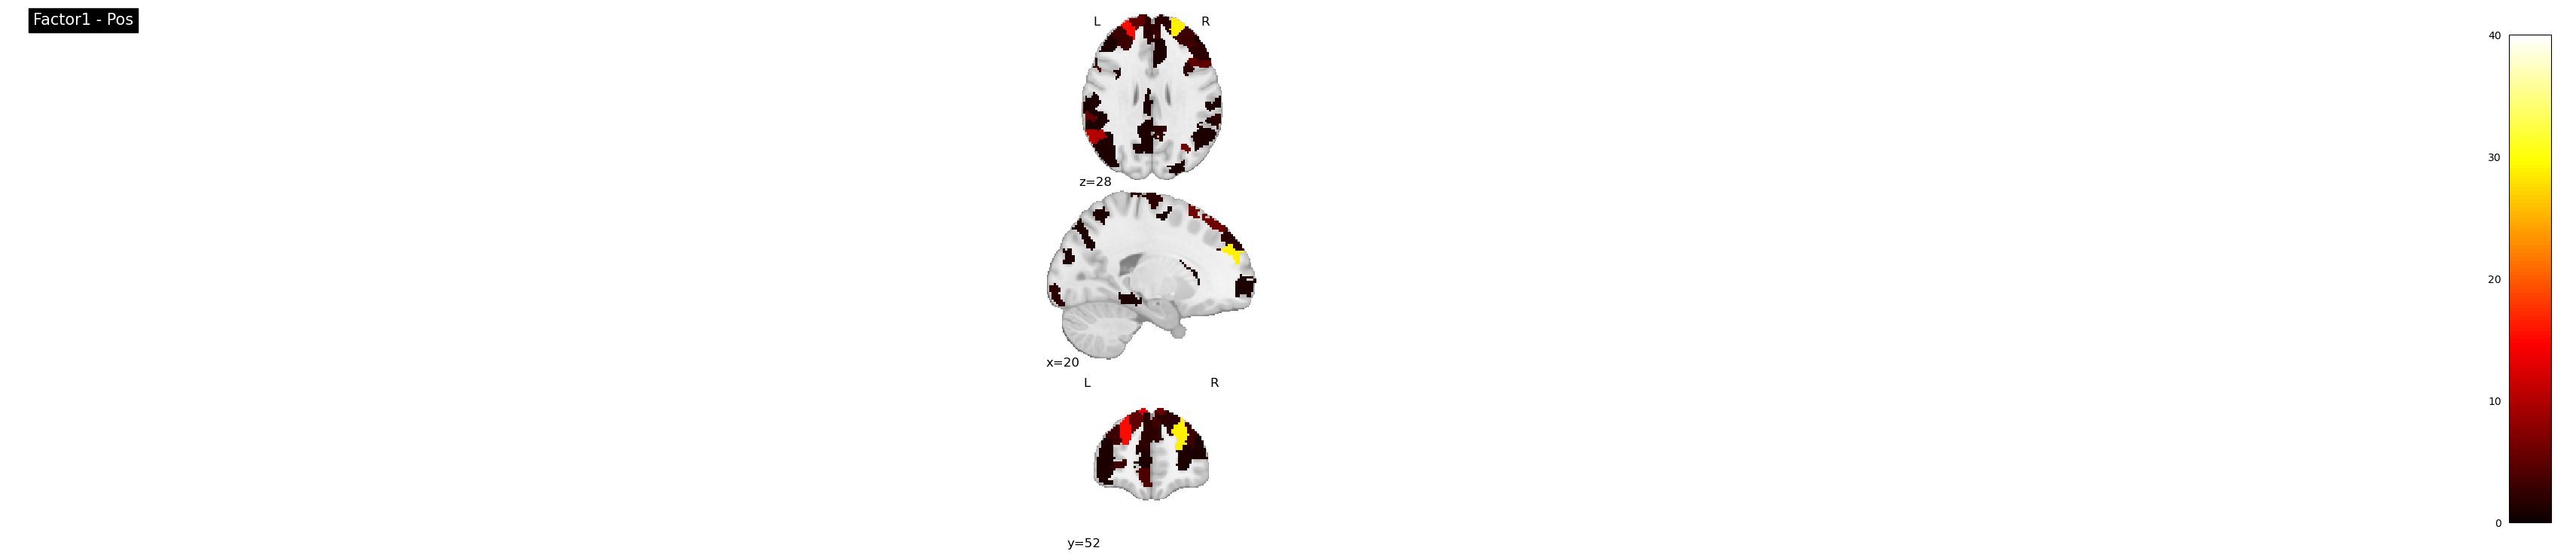

In [25]:
plot_stat_map('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-pos_Degree.nii',vmax=40, draw_cross=False, display_mode='mosaic', cut_coords=1, title='Factor1 - Pos')

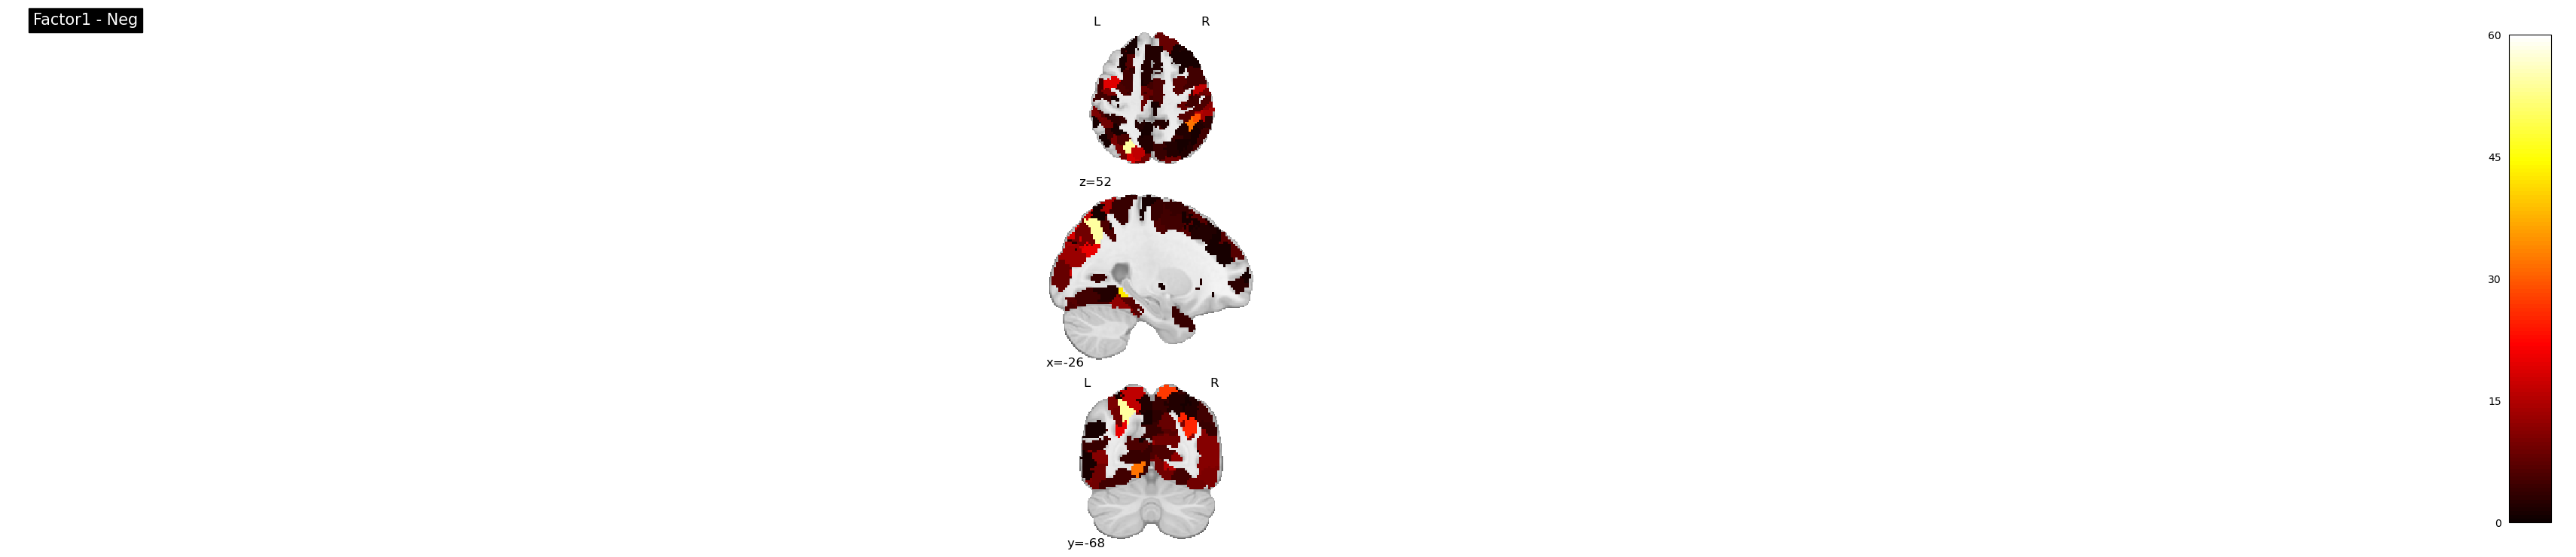

In [26]:
plot_stat_map('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor1-neg_Degree.nii',vmax=60, draw_cross=False, display_mode='mosaic', cut_coords=1, title='Factor1 - Neg')

### 4.1.1. Show Top Degree ROI used for decoding

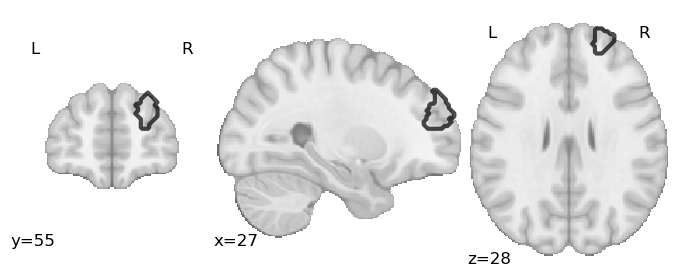

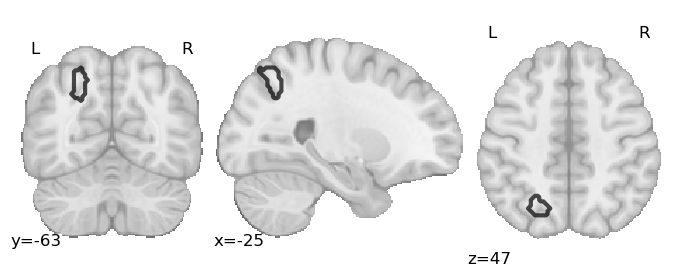

In [29]:
top_degree_roi, top_degree_roi_path = {},{}
for item,model,coords in [['Factor1','pos',[27,55,28]],
                          ['Factor1','neg',[-25,-63,47]]]:
    top_degree_roi_path[item,model]    =  osp.join(RESOURCES_NIMARE_DIR,f'{item}-{model}_Degree_Top0_ROI.nii')
    top_degree_roi[item,model]         = load_img(top_degree_roi_path[item,model])
    f = plot_roi(top_degree_roi[item,model],draw_cross=False, display_mode='ortho', linewidths=3, cut_coords=coords, view_type='contours', cmap=roi_cmap)

### 4.1.2. Gather the studies with coordinates that overlap with the ROI

In [32]:
# Get studies with voxels in the mask
ids = {}
for item,model in [['Factor1','pos'],['Factor1','neg']]:
    ids[item,model] = neurosynth_dset.get_studies_by_mask(top_degree_roi[item,model])
    print('++INFO: Number of studies that overlap with the ROI [%s,%s]: %d stduies' % (item,model,len(ids[item,model])))

++INFO: Number of studies that overlap with the ROI [Factor1,pos]: 534 stduies
++INFO: Number of studies that overlap with the ROI [Factor1,neg]: 990 stduies


### 4.1.3. Decode using the Chi-Method

In [35]:
decoders, decoded_df, selected_topics = {},{},{}
for item,model in [['Factor1','pos'],['Factor1','neg']]:
    # Run the decoder
    decoders[item,model] = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
    decoders[item,model].fit(neurosynth_dset)
    decoded_df[item,model]      = decoders[item,model].transform(ids=ids[item,model])
    selected_topics[item,model] = decoded_df[item,model][decoded_df[item,model]['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
    print('[%s,%s] Number of topics that correlate significantly with the ROI = %d topics' % (item,model,selected_topics[item,model].shape[0]))

[Factor1,pos] Number of topics that correlate significantly with the ROI = 3 topics
[Factor1,neg] Number of topics that correlate significantly with the ROI = 15 topics


### 4.1.4. WordCloud Generation F1 - Positive

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [38]:
freqs_df = {}
for item,model in [['Factor1','pos'],['Factor1','neg']]:
    freqs_df[item,model] = pd.Series(dtype=float)
    if vocab == 'terms':
        for term_long,row in selected_topics[item,model].iterrows():
            term = term_long.split('__')[1]
            term_prob = row['probReverse']
            if term in freqs_df[item,model].index:
                freqs_df[item,model][term] = freqs_df[item,model][term] + term_prob
            else:
                freqs_df[item,model][term] = term_prob
    else:
        for topic in selected_topics[item,model].index:
            this_topic_prob = selected_topics[item,model].loc[topic,'probReverse']
            for word,weight in term_weights_per_topic[topic].items():
                if word in freqs_df[item,model].index:
                    freqs_df[item,model][word] = freqs_df[item,model][word] + (this_topic_prob * weight)
                else:
                    freqs_df[item,model][word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [39]:
for item,model in [['Factor1','pos'],['Factor1','neg']]:
    freqs_df[item,model].drop(my_stopwords,errors='ignore', inplace=True)
    freqs_df[item,model]  = freqs_df[item,model].sort_values(ascending=False)[0:30]
    print(freqs_df[item,model].head(5))

control       46.567372
response      44.281246
error         31.998652
inhibition    23.800028
conflict      22.793161
dtype: float64
visual        66.323537
spatial       60.866045
response      51.016086
stimulus      50.162729
perception    48.993622
dtype: float64


In [40]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr, freqs_df_color = {},{}
for item,model in [['Factor1','pos'],['Factor1','neg']]:
    freqs_arr[item,model] = freqs_df[item,model].values
    freqs_arr[item,model] = freqs_arr[item,model].reshape(-1,1)
    freqs_arr[item,model] = MinMaxScaler((25,99)).fit_transform(freqs_arr[item,model])
    freqs_df_color[item,model] = pd.Series(freqs_arr[item,model].flatten(),index=freqs_df[item,model].index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [41]:
freqs_dict, freqs_color_dict = {},{}
for item,model in [['Factor1','pos'],['Factor1','neg']]:
    freqs_dict[item,model] = freqs_df[item,model].to_dict()
    freqs_color_dict[item,model] = freqs_df_color[item,model].to_dict()

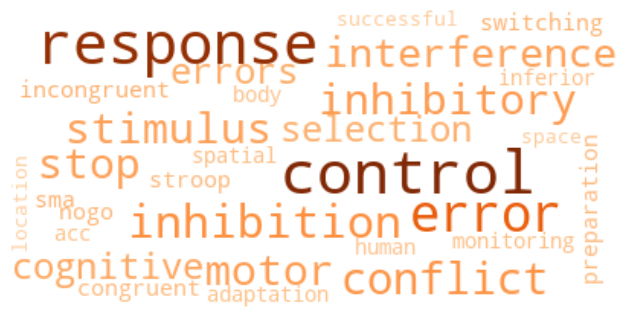

In [44]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_orange_color_func(freqs_color_dict['Factor1','pos']),
                   repeat=False).generate_from_frequencies(freqs_dict['Factor1','pos'])
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

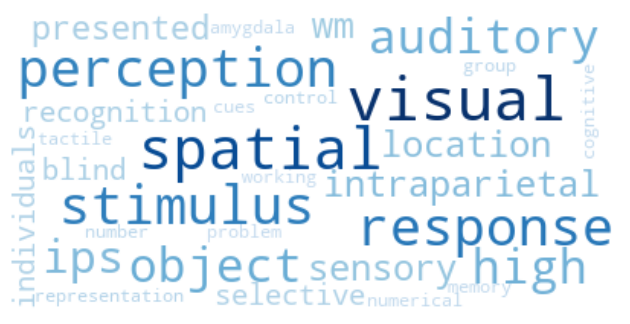

In [46]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_blue_color_func(freqs_color_dict['Factor1','neg']),
                   repeat=False).generate_from_frequencies(freqs_dict['Factor1','neg'])
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

## 4.2. NBS - Images
### 4.1.1. Show areas with highest degree

In [48]:
top_degree_list_F1_pos = CPM_Gatts['Images','pos'].drop(['Degree_Centrality','Eigenvector_Centrality','Page_Rank'],axis=1).copy()
top_degree_list_F1_pos.index = top_degree_list_F1_pos.index.droplevel(['RGB','ROI_ID','Network','Hemisphere'])
top_degree_list_F1_pos.index.name = 'Images - Positive'
top_degree_list_F1_neg = CPM_Gatts['Images','neg'].drop(['Degree_Centrality','Eigenvector_Centrality','Page_Rank'],axis=1).copy()
top_degree_list_F1_neg.index = top_degree_list_F1_neg.index.droplevel(['RGB','ROI_ID','Network','Hemisphere'])
top_degree_list_F1_neg.index.name = 'Images - Negative'
pn.Row(top_degree_list_F1_pos.sort_values(by='Degree', ascending=False).head(5),top_degree_list_F1_neg.sort_values(by='Degree', ascending=False).head(5))

Row
    [0] DataFrame(DataFrame)
    [1] DataFrame(DataFrame)

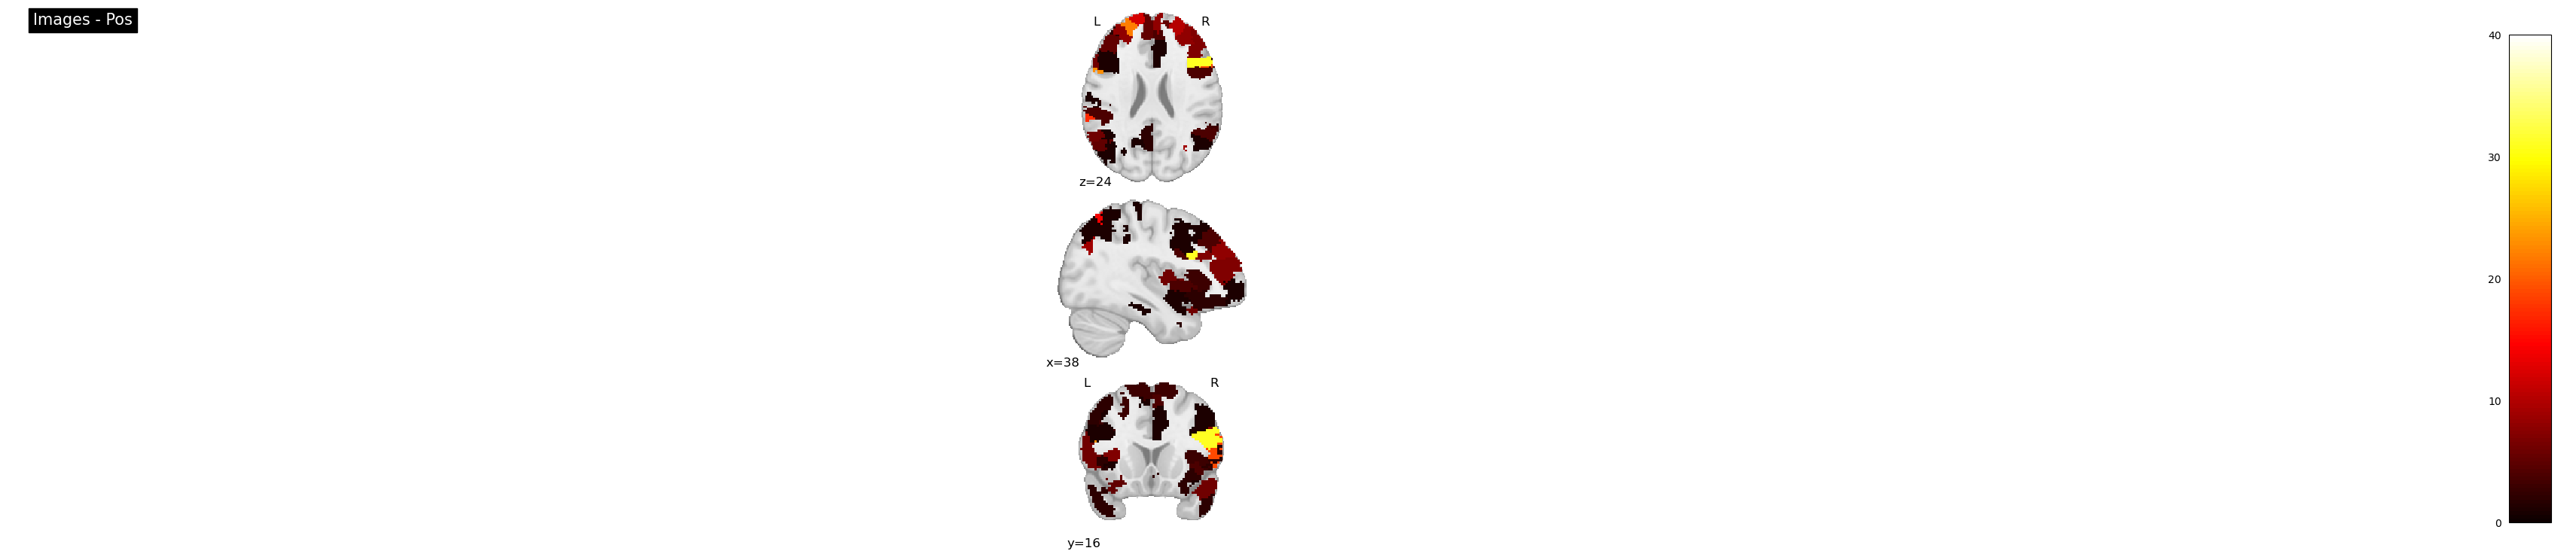

In [49]:
plot_stat_map('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Images-pos_Degree.nii',vmax=40, draw_cross=False, display_mode='mosaic', cut_coords=1, title='Images - Pos')

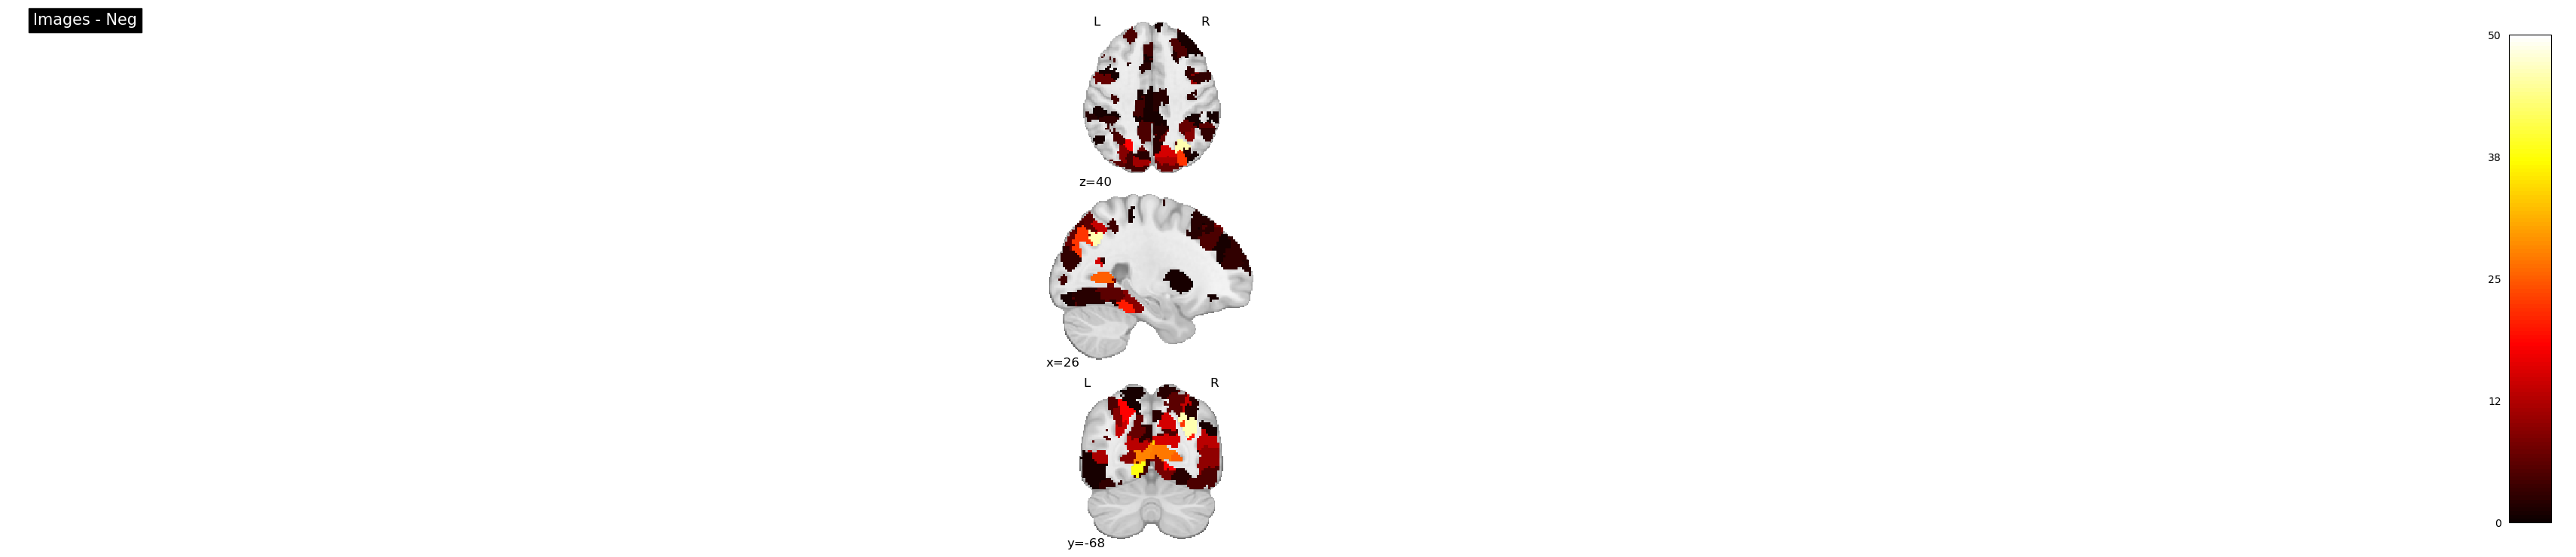

In [52]:
plot_stat_map('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Images-neg_Degree.nii',vmax=50, draw_cross=False, display_mode='mosaic', cut_coords=1, title='Images - Neg')

### 4.1.1. Show Top Degree ROI used for decoding

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)


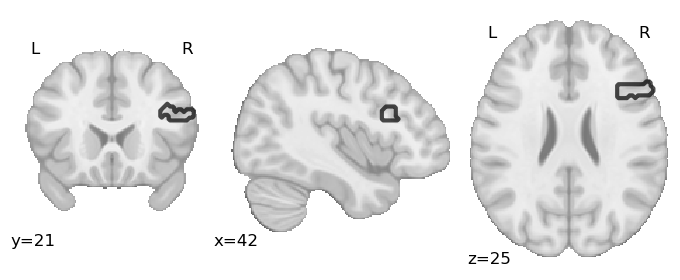

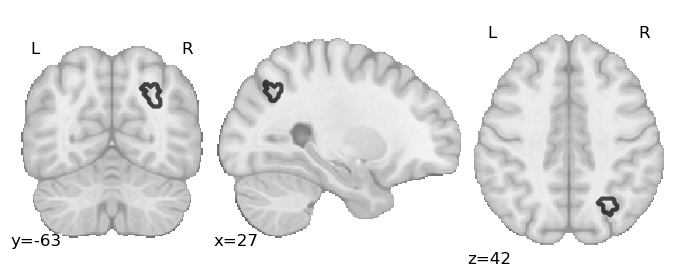

In [53]:
top_degree_roi, top_degree_roi_path = {},{}
for item,model,coords in [['Images','pos',[42,21,25]],
                          ['Images','neg',[27,-63,42]]]:
    top_degree_roi_path[item,model]    =  osp.join(RESOURCES_NIMARE_DIR,f'{item}-{model}_Degree_Top0_ROI.nii')
    top_degree_roi[item,model]         = load_img(top_degree_roi_path[item,model])
    f = plot_roi(top_degree_roi[item,model],draw_cross=False, display_mode='ortho', linewidths=3, cut_coords=coords, view_type='contours', cmap=roi_cmap)

### 4.1.2. Gather the studies with coordinates that overlap with the ROI

In [54]:
# Get studies with voxels in the mask
ids = {}
for item,model in [['Images','pos'],['Images','neg']]:
    ids[item,model] = neurosynth_dset.get_studies_by_mask(top_degree_roi[item,model])
    print('++INFO: Number of studies that overlap with the ROI [%s,%s]: %d stduies' % (item,model,len(ids[item,model])))

++INFO: Number of studies that overlap with the ROI [Images,pos]: 964 stduies
++INFO: Number of studies that overlap with the ROI [Images,neg]: 828 stduies


### 4.1.3. Decode using the Chi-Method

In [55]:
decoders, decoded_df, selected_topics = {},{},{}
for item,model in [['Images','pos'],['Images','neg']]:
    # Run the decoder
    decoders[item,model] = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
    decoders[item,model].fit(neurosynth_dset)
    decoded_df[item,model]      = decoders[item,model].transform(ids=ids[item,model])
    selected_topics[item,model] = decoded_df[item,model][decoded_df[item,model]['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
    print('[%s,%s] Number of topics that correlate significantly with the ROI = %d topics' % (item,model,selected_topics[item,model].shape[0]))

[Images,pos] Number of topics that correlate significantly with the ROI = 4 topics
[Images,neg] Number of topics that correlate significantly with the ROI = 11 topics


### 4.1.4. WordCloud Generation F1 - Positive

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [56]:
freqs_df = {}
for item,model in [['Images','pos'],['Images','neg']]:
    freqs_df[item,model] = pd.Series(dtype=float)
    if vocab == 'terms':
        for term_long,row in selected_topics[item,model].iterrows():
            term = term_long.split('__')[1]
            term_prob = row['probReverse']
            if term in freqs_df[item,model].index:
                freqs_df[item,model][term] = freqs_df[item,model][term] + term_prob
            else:
                freqs_df[item,model][term] = term_prob
    else:
        for topic in selected_topics[item,model].index:
            this_topic_prob = selected_topics[item,model].loc[topic,'probReverse']
            for word,weight in term_weights_per_topic[topic].items():
                if word in freqs_df[item,model].index:
                    freqs_df[item,model][word] = freqs_df[item,model][word] + (this_topic_prob * weight)
                else:
                    freqs_df[item,model][word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [57]:
for item,model in [['Images','pos'],['Images','neg']]:
    freqs_df[item,model].drop(my_stopwords,errors='ignore', inplace=True)
    freqs_df[item,model]  = freqs_df[item,model].sort_values(ascending=False)[0:30]
    print(freqs_df[item,model].head(5))

face           23.575614
faces          22.986223
facial         22.396833
expressions    21.807443
recognition    21.218052
dtype: float64
spatial      55.884873
memory       45.441921
control      44.420479
cognitive    42.053473
stimulus     39.182462
dtype: float64


In [58]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr, freqs_df_color = {},{}
for item,model in [['Images','pos'],['Images','neg']]:
    freqs_arr[item,model] = freqs_df[item,model].values
    freqs_arr[item,model] = freqs_arr[item,model].reshape(-1,1)
    freqs_arr[item,model] = MinMaxScaler((25,99)).fit_transform(freqs_arr[item,model])
    freqs_df_color[item,model] = pd.Series(freqs_arr[item,model].flatten(),index=freqs_df[item,model].index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [59]:
freqs_dict, freqs_color_dict = {},{}
for item,model in [['Images','pos'],['Images','neg']]:
    freqs_dict[item,model] = freqs_df[item,model].to_dict()
    freqs_color_dict[item,model] = freqs_df_color[item,model].to_dict()

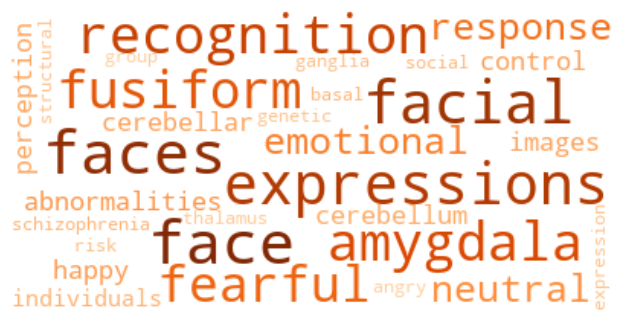

In [60]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_orange_color_func(freqs_color_dict['Images','pos']),
                   repeat=False).generate_from_frequencies(freqs_dict['Images','pos'])
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

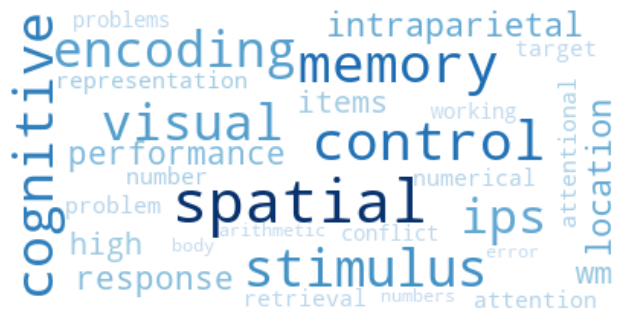

In [61]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_blue_color_func(freqs_color_dict['Images','neg']),
                   repeat=False).generate_from_frequencies(freqs_dict['Images','neg'])
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

## 4.3. NBS - Factor2
### 4.1.1. Show areas with highest degree

In [63]:
top_degree_list_F1_pos = CPM_Gatts['Factor2','pos'].drop(['Degree_Centrality','Eigenvector_Centrality','Page_Rank'],axis=1).copy()
top_degree_list_F1_pos.index = top_degree_list_F1_pos.index.droplevel(['RGB','ROI_ID','Network','Hemisphere'])
top_degree_list_F1_pos.index.name = 'Factor2 - Positive'
top_degree_list_F1_neg = CPM_Gatts['Factor2','neg'].drop(['Degree_Centrality','Eigenvector_Centrality','Page_Rank'],axis=1).copy()
top_degree_list_F1_neg.index = top_degree_list_F1_neg.index.droplevel(['RGB','ROI_ID','Network','Hemisphere'])
top_degree_list_F1_neg.index.name = 'Factor2 - Negative'
pn.Row(top_degree_list_F1_pos.sort_values(by='Degree', ascending=False).head(5),top_degree_list_F1_neg.sort_values(by='Degree', ascending=False).head(5))

Row
    [0] DataFrame(DataFrame)
    [1] DataFrame(DataFrame)

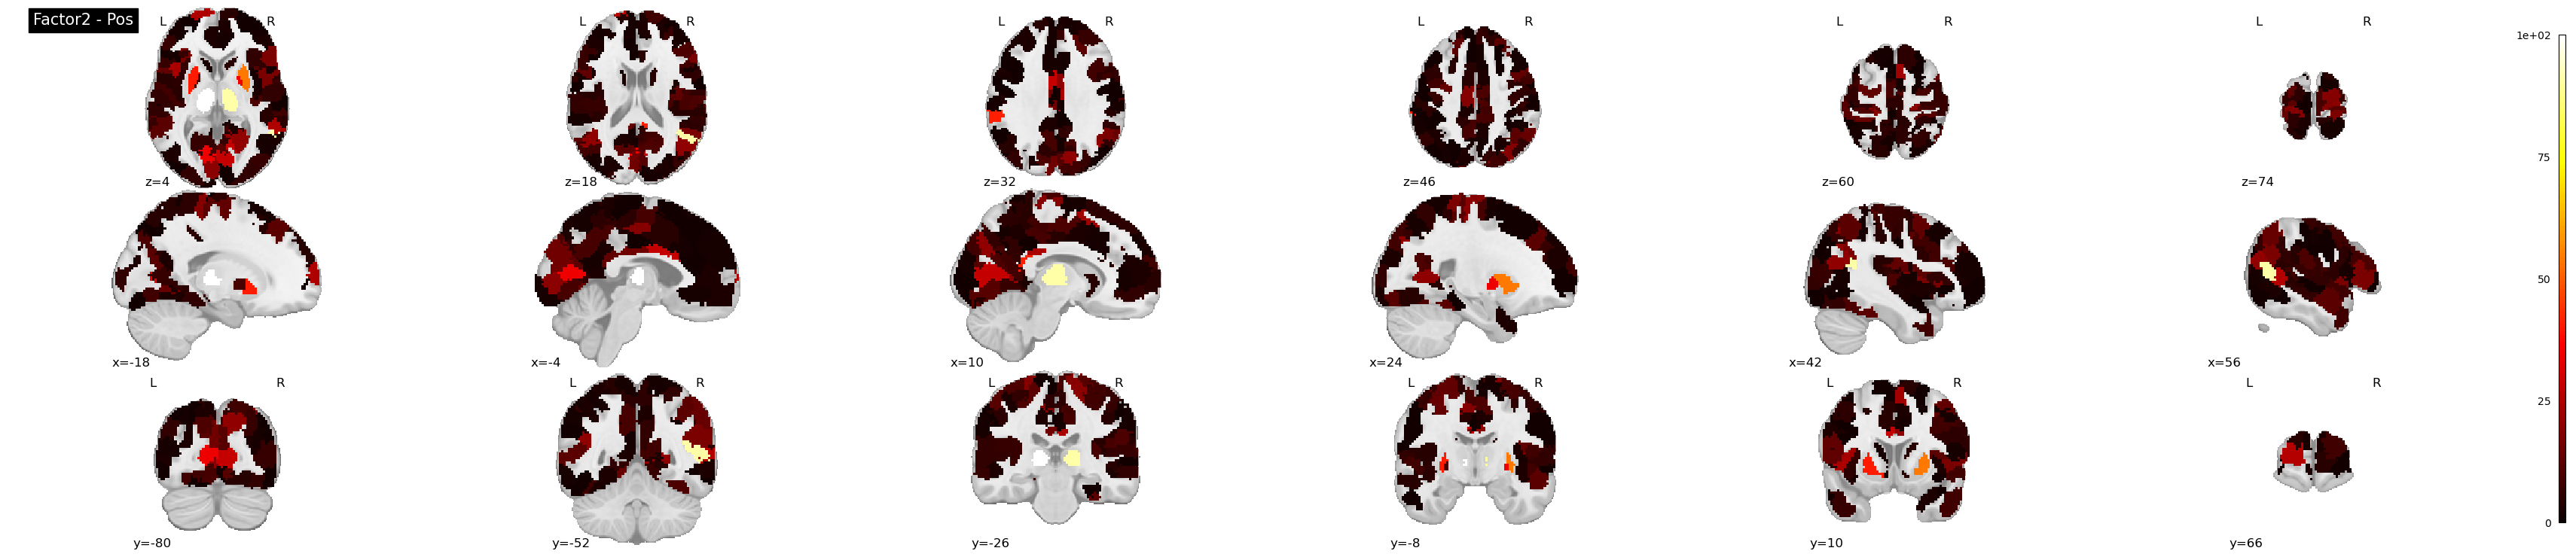

In [67]:
plot_stat_map('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor2-pos_Degree.nii',vmax=100, draw_cross=False, display_mode='mosaic', cut_coords=6, title='Factor2 - Pos')

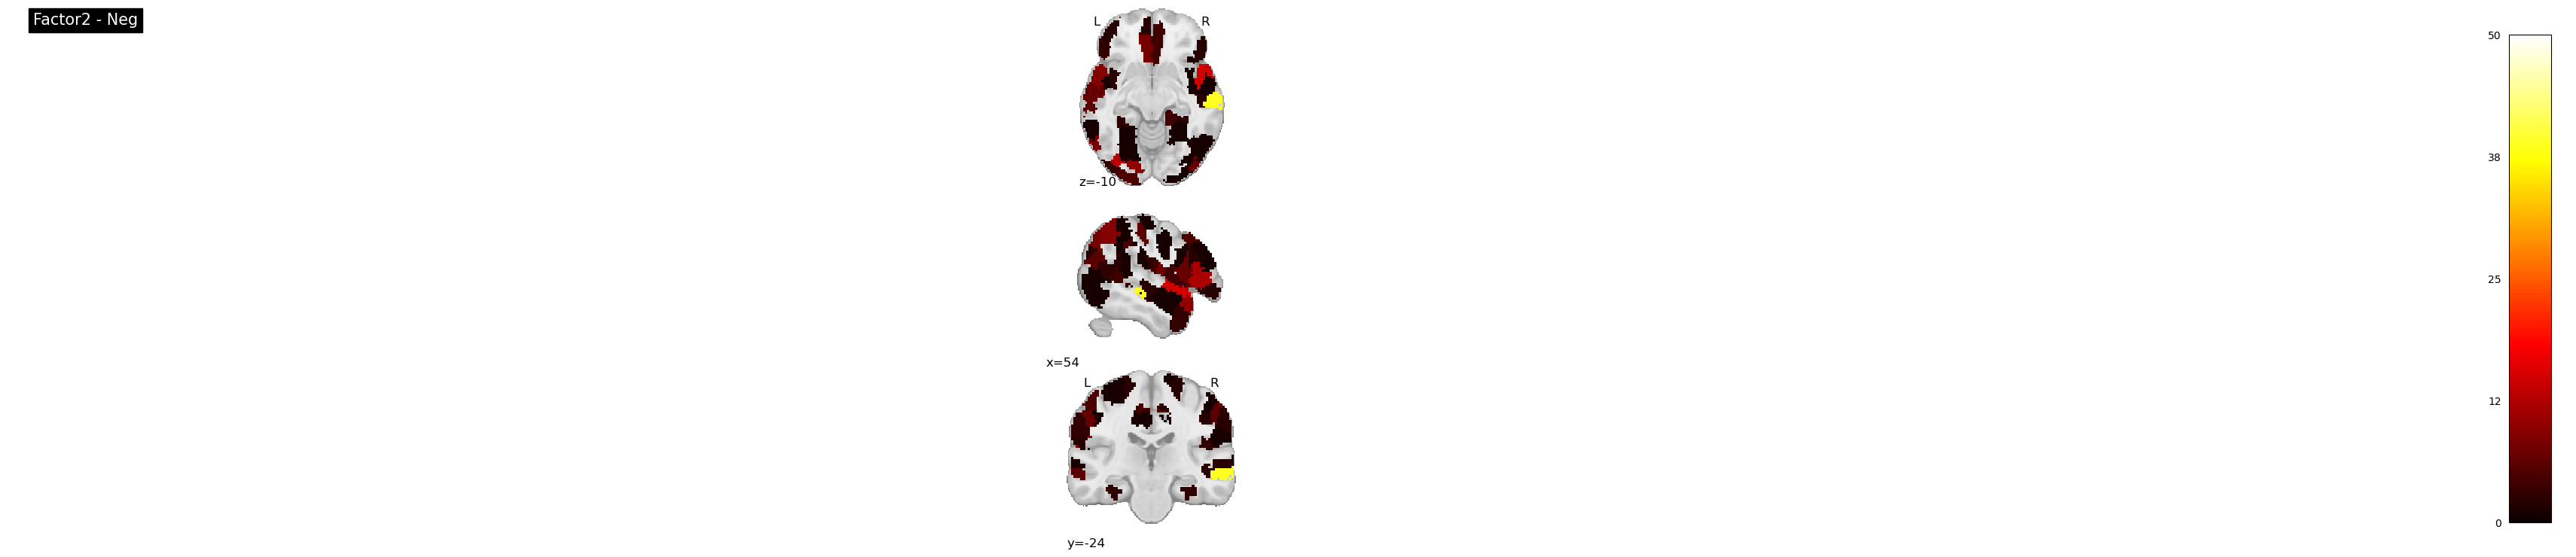

In [72]:
plot_stat_map('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Factor2-neg_Degree.nii',vmax=50, draw_cross=False, display_mode='mosaic', cut_coords=1, title='Factor2 - Neg')

### 4.1.1. Show Top Degree ROI used for decoding

+++++ WARNING ++++ Hardcoded alternative --> CHECK THINGS


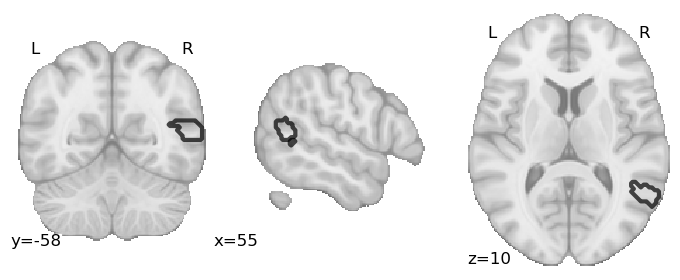

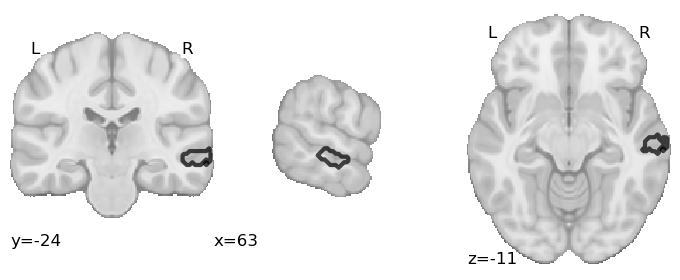

In [71]:
top_degree_roi, top_degree_roi_path = {},{}
for item,model,coords in [['Factor2','pos',[55,-58,10]],
                          ['Factor2','neg',[63,-24,-11]]]:
    if model == 'pos':
        print('+++++ WARNING ++++ Hardcoded alternative --> CHECK THINGS')
        top_degree_roi_path[item,model]    =  osp.join(RESOURCES_NIMARE_DIR,f'{item}-{model}_Degree_Top1_ROI.nii')
    else:
        top_degree_roi_path[item,model]    =  osp.join(RESOURCES_NIMARE_DIR,f'{item}-{model}_Degree_Top0_ROI.nii')

    top_degree_roi[item,model]         = load_img(top_degree_roi_path[item,model])
    f = plot_roi(top_degree_roi[item,model],draw_cross=False, display_mode='ortho', linewidths=3, cut_coords=coords, view_type='contours', cmap=roi_cmap)

### 4.1.2. Gather the studies with coordinates that overlap with the ROI

In [73]:
# Get studies with voxels in the mask
ids = {}
for item,model in [['Factor2','pos'],['Factor2','neg']]:
    ids[item,model] = neurosynth_dset.get_studies_by_mask(top_degree_roi[item,model])
    print('++INFO: Number of studies that overlap with the ROI [%s,%s]: %d stduies' % (item,model,len(ids[item,model])))

++INFO: Number of studies that overlap with the ROI [Factor2,pos]: 670 stduies
++INFO: Number of studies that overlap with the ROI [Factor2,neg]: 504 stduies


### 4.1.3. Decode using the Chi-Method

In [74]:
decoders, decoded_df, selected_topics = {},{},{}
for item,model in [['Factor2','pos'],['Factor2','neg']]:
    # Run the decoder
    decoders[item,model] = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
    decoders[item,model].fit(neurosynth_dset)
    decoded_df[item,model]      = decoders[item,model].transform(ids=ids[item,model])
    selected_topics[item,model] = decoded_df[item,model][decoded_df[item,model]['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
    print('[%s,%s] Number of topics that correlate significantly with the ROI = %d topics' % (item,model,selected_topics[item,model].shape[0]))

[Factor2,pos] Number of topics that correlate significantly with the ROI = 6 topics
[Factor2,neg] Number of topics that correlate significantly with the ROI = 4 topics


### 4.1.4. WordCloud Generation F1 - Positive

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [75]:
freqs_df = {}
for item,model in [['Factor2','pos'],['Factor2','neg']]:
    freqs_df[item,model] = pd.Series(dtype=float)
    if vocab == 'terms':
        for term_long,row in selected_topics[item,model].iterrows():
            term = term_long.split('__')[1]
            term_prob = row['probReverse']
            if term in freqs_df[item,model].index:
                freqs_df[item,model][term] = freqs_df[item,model][term] + term_prob
            else:
                freqs_df[item,model][term] = term_prob
    else:
        for topic in selected_topics[item,model].index:
            this_topic_prob = selected_topics[item,model].loc[topic,'probReverse']
            for word,weight in term_weights_per_topic[topic].items():
                if word in freqs_df[item,model].index:
                    freqs_df[item,model][word] = freqs_df[item,model][word] + (this_topic_prob * weight)
                else:
                    freqs_df[item,model][word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [76]:
for item,model in [['Factor2','pos'],['Factor2','neg']]:
    freqs_df[item,model].drop(my_stopwords,errors='ignore', inplace=True)
    freqs_df[item,model]  = freqs_df[item,model].sort_values(ascending=False)[0:30]
    print(freqs_df[item,model].head(5))

social        64.414091
human         49.597990
perception    46.116525
person        36.472934
people        31.959120
dtype: float64
auditory      29.816069
speech        29.070667
sounds        27.579864
production    26.878767
superior      26.834462
dtype: float64


In [77]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr, freqs_df_color = {},{}
for item,model in [['Factor2','pos'],['Factor2','neg']]:
    freqs_arr[item,model] = freqs_df[item,model].values
    freqs_arr[item,model] = freqs_arr[item,model].reshape(-1,1)
    freqs_arr[item,model] = MinMaxScaler((25,99)).fit_transform(freqs_arr[item,model])
    freqs_df_color[item,model] = pd.Series(freqs_arr[item,model].flatten(),index=freqs_df[item,model].index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [78]:
freqs_dict, freqs_color_dict = {},{}
for item,model in [['Factor2','pos'],['Factor2','neg']]:
    freqs_dict[item,model] = freqs_df[item,model].to_dict()
    freqs_color_dict[item,model] = freqs_df_color[item,model].to_dict()

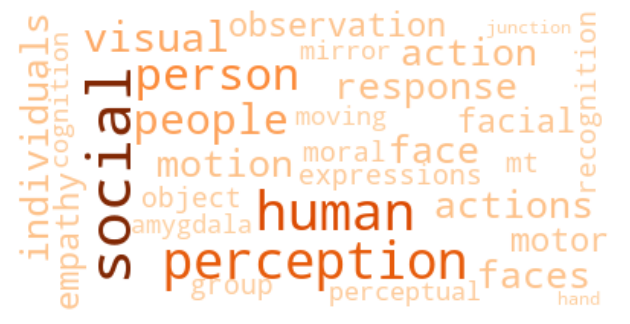

In [79]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_orange_color_func(freqs_color_dict['Factor2','pos']),
                   repeat=False).generate_from_frequencies(freqs_dict['Factor2','pos'])
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

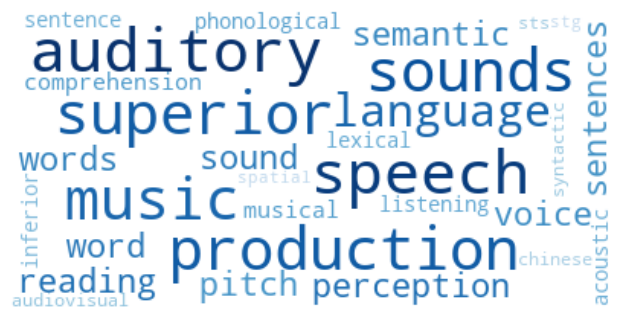

In [80]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_blue_color_func(freqs_color_dict['Factor2','neg']),
                   repeat=False).generate_from_frequencies(freqs_dict['Factor2','neg'])
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

## 4.3. NBS - Surroundings

### 4.3.1. Show areas with highest degree

In [81]:
top_degree_list_F1_pos = CPM_Gatts['Surroundings','pos'].drop(['Degree_Centrality','Eigenvector_Centrality','Page_Rank'],axis=1).copy()
top_degree_list_F1_pos.index = top_degree_list_F1_pos.index.droplevel(['RGB','ROI_ID','Network','Hemisphere'])
top_degree_list_F1_pos.index.name = 'Surroundings - Positive'
top_degree_list_F1_neg = CPM_Gatts['Surroundings','neg'].drop(['Degree_Centrality','Eigenvector_Centrality','Page_Rank'],axis=1).copy()
top_degree_list_F1_neg.index = top_degree_list_F1_neg.index.droplevel(['RGB','ROI_ID','Network','Hemisphere'])
top_degree_list_F1_neg.index.name = 'Surroundings - Negative'
pn.Row(top_degree_list_F1_pos.sort_values(by='Degree', ascending=False).head(5),top_degree_list_F1_neg.sort_values(by='Degree', ascending=False).head(5))

Row
    [0] DataFrame(DataFrame)
    [1] DataFrame(DataFrame)

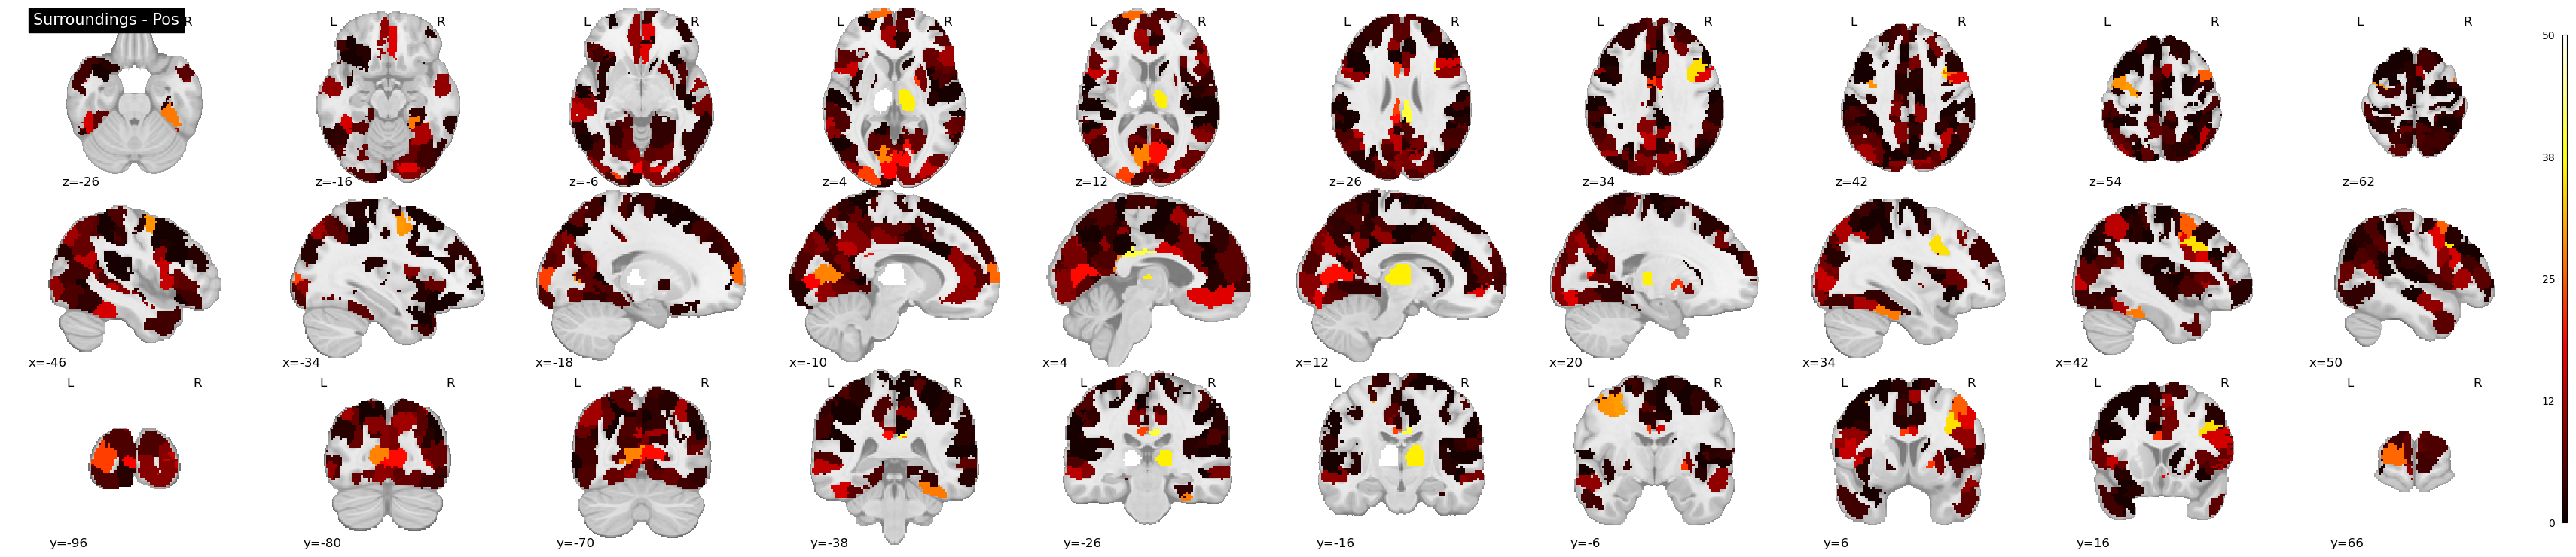

In [88]:
plot_stat_map('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Surroundings-pos_Degree.nii',vmax=50, draw_cross=False, display_mode='mosaic', cut_coords=10, title='Surroundings - Pos')

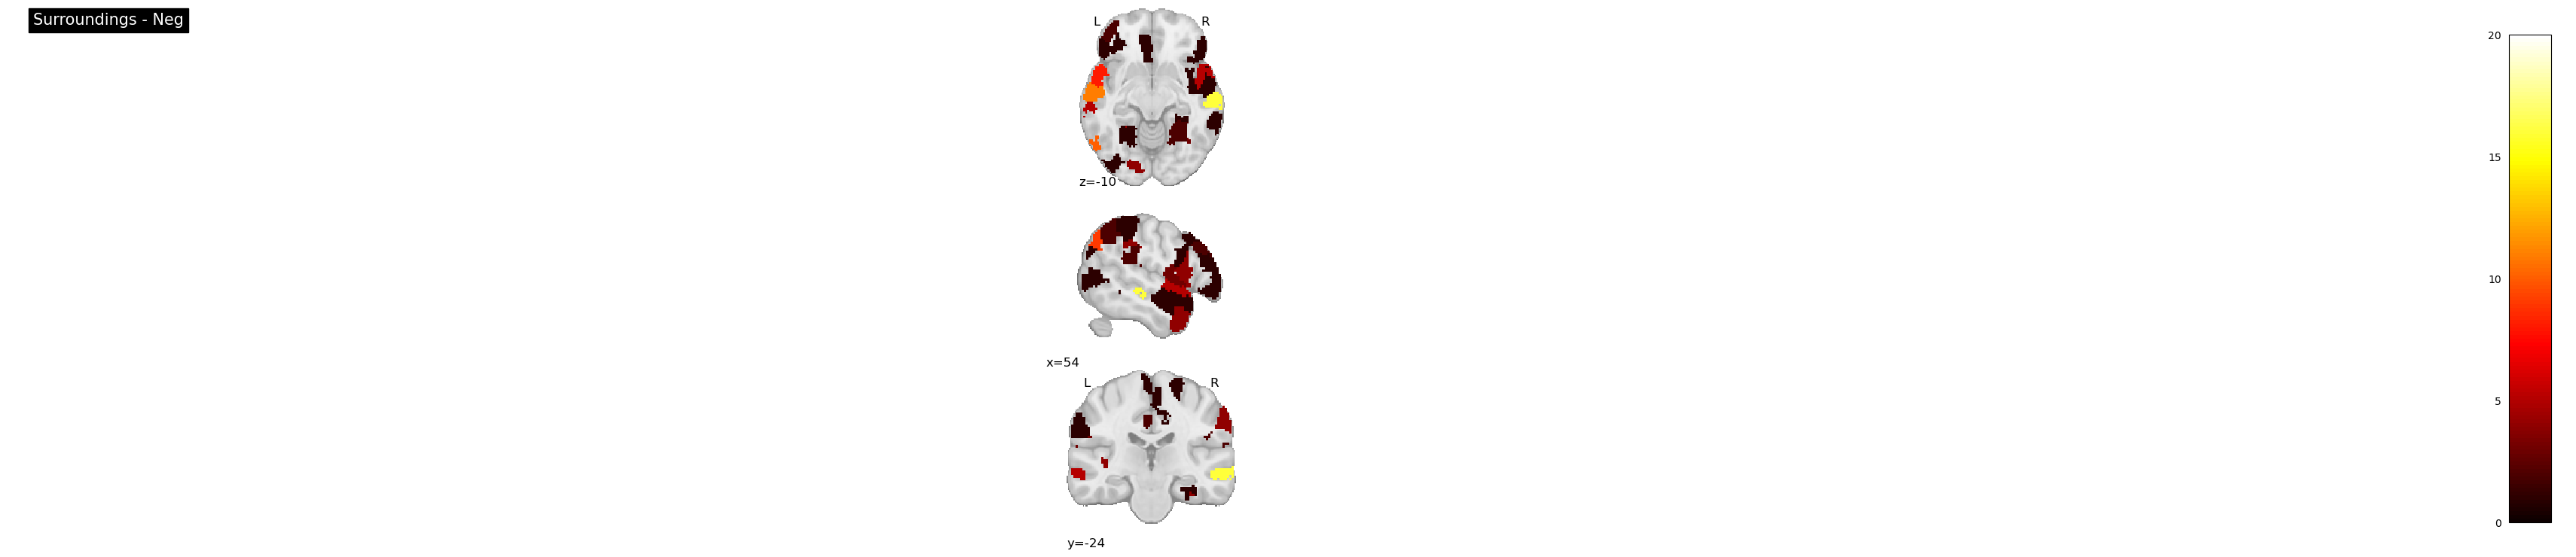

In [87]:
plot_stat_map('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Surroundings-neg_Degree.nii',vmax=20, draw_cross=False, display_mode='mosaic', cut_coords=1, title='Surroundings - Neg')

### 4.1.1. Show Top Degree ROI used for decoding

+++++ WARNING ++++ Hardcoded alternative --> CHECK THINGS


/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)


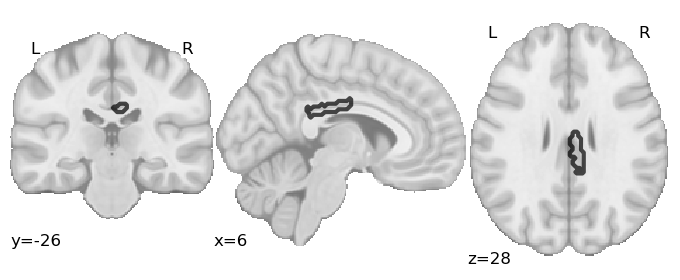

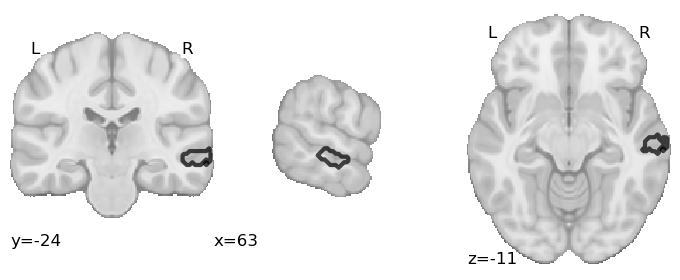

In [84]:
top_degree_roi, top_degree_roi_path = {},{}
for item,model,coords in [['Surroundings','pos',[6,-26,28]],
                          ['Surroundings','neg',[63,-24,-11]]]:
    if model == 'pos':
        print('+++++ WARNING ++++ Hardcoded alternative --> CHECK THINGS')
        top_degree_roi_path[item,model]    =  osp.join(RESOURCES_NIMARE_DIR,f'{item}-{model}_Degree_Top1_ROI.nii')
    else:
        top_degree_roi_path[item,model]    =  osp.join(RESOURCES_NIMARE_DIR,f'{item}-{model}_Degree_Top0_ROI.nii')
    top_degree_roi[item,model]         = load_img(top_degree_roi_path[item,model])
    f = plot_roi(top_degree_roi[item,model],draw_cross=False, display_mode='ortho', linewidths=3, cut_coords=coords, view_type='contours', cmap=roi_cmap)

### 4.1.2. Gather the studies with coordinates that overlap with the ROI

In [89]:
# Get studies with voxels in the mask
ids = {}
for item,model in [['Surroundings','pos'],['Surroundings','neg']]:
    ids[item,model] = neurosynth_dset.get_studies_by_mask(top_degree_roi[item,model])
    print('++INFO: Number of studies that overlap with the ROI [%s,%s]: %d stduies' % (item,model,len(ids[item,model])))

++INFO: Number of studies that overlap with the ROI [Surroundings,pos]: 249 stduies
++INFO: Number of studies that overlap with the ROI [Surroundings,neg]: 504 stduies


### 4.1.3. Decode using the Chi-Method

In [90]:
decoders, decoded_df, selected_topics = {},{},{}
for item,model in [['Surroundings','pos'],['Surroundings','neg']]:
    # Run the decoder
    decoders[item,model] = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
    decoders[item,model].fit(neurosynth_dset)
    decoded_df[item,model]      = decoders[item,model].transform(ids=ids[item,model])
    selected_topics[item,model] = decoded_df[item,model][decoded_df[item,model]['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
    print('[%s,%s] Number of topics that correlate significantly with the ROI = %d topics' % (item,model,selected_topics[item,model].shape[0]))

[Surroundings,pos] Number of topics that correlate significantly with the ROI = 0 topics
[Surroundings,neg] Number of topics that correlate significantly with the ROI = 4 topics


### 4.1.4. WordCloud Generation F1 - Positive

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [91]:
freqs_df = {}
for item,model in [['Surroundings','pos'],['Surroundings','neg']]:
    freqs_df[item,model] = pd.Series(dtype=float)
    if vocab == 'terms':
        for term_long,row in selected_topics[item,model].iterrows():
            term = term_long.split('__')[1]
            term_prob = row['probReverse']
            if term in freqs_df[item,model].index:
                freqs_df[item,model][term] = freqs_df[item,model][term] + term_prob
            else:
                freqs_df[item,model][term] = term_prob
    else:
        for topic in selected_topics[item,model].index:
            this_topic_prob = selected_topics[item,model].loc[topic,'probReverse']
            for word,weight in term_weights_per_topic[topic].items():
                if word in freqs_df[item,model].index:
                    freqs_df[item,model][word] = freqs_df[item,model][word] + (this_topic_prob * weight)
                else:
                    freqs_df[item,model][word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [92]:
for item,model in [['Surroundings','pos'],['Surroundings','neg']]:
    freqs_df[item,model].drop(my_stopwords,errors='ignore', inplace=True)
    freqs_df[item,model]  = freqs_df[item,model].sort_values(ascending=False)[0:30]
    print(freqs_df[item,model].head(5))

Series([], dtype: float64)
auditory      29.816069
speech        29.070667
sounds        27.579864
production    26.878767
superior      26.834462
dtype: float64


In [100]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr, freqs_df_color = {},{}
for item,model in [['Surroundings','pos'],['Surroundings','neg']]:
    if freqs_df[item,model].shape[0] > 0:
        freqs_arr[item,model] = freqs_df[item,model].values
        freqs_arr[item,model] = freqs_arr[item,model].reshape(-1,1)
        freqs_arr[item,model] = MinMaxScaler((25,99)).fit_transform(freqs_arr[item,model])
        freqs_df_color[item,model] = pd.Series(freqs_arr[item,model].flatten(),index=freqs_df[item,model].index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [104]:
freqs_dict, freqs_color_dict = {},{}
for item,model in freqs_arr.keys():
    freqs_dict[item,model] = freqs_df[item,model].to_dict()
    freqs_color_dict[item,model] = freqs_df_color[item,model].to_dict()

In [105]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_orange_color_func(freqs_color_dict['Surroundings','pos']),
                   repeat=False).generate_from_frequencies(freqs_dict['Surroundings','pos'])
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

KeyError: ('Surroundings', 'pos')

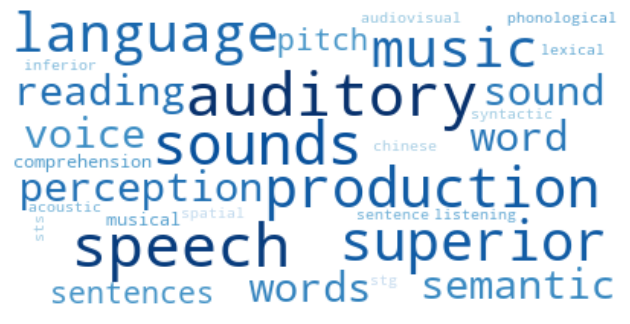

In [106]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_blue_color_func(freqs_color_dict['Surroundings','neg']),
                   repeat=False).generate_from_frequencies(freqs_dict['Surroundings','neg'])
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

## 4.2. Surr-Neg-Self > Images-Pos-Others

### 4.2.1. Load the target ROI

In [100]:
top_degree_roi_path =  osp.join(RESOURCES_NIMARE_DIR,'Images-neg_Degree_Top0_ROI.nii')
top_degree_roi      = load_img(top_degree_roi_path)

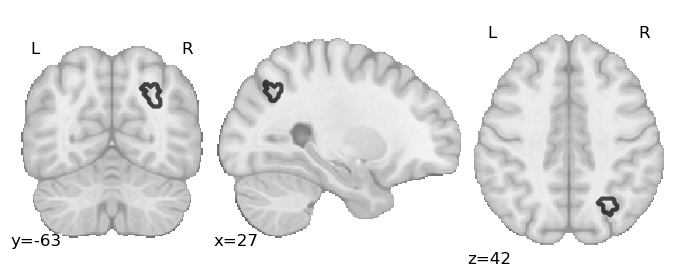

In [107]:
f = plot_roi(top_degree_roi,draw_cross=False, display_mode='ortho', linewidths=3, cut_coords=[27,-63,42], view_type='contours', cmap=roi_cmap)

In [60]:
#f.savefig('./figures/S14b_f2GTf1_TopDegree_ROI.png')

### 4.2.2. Gather the studies with coordinates that overlap with the ROI

In [61]:
# Get studies with voxels in the mask
ids = neurosynth_dset.get_studies_by_mask(top_degree_roi)
print('++INFO: Number of studies that overlap with the ROI: %d stduies' % len(ids))

++INFO: Number of studies that overlap with the ROI: 990 stduies


### 4.2.3. Decode using the Chi-Method

In [62]:
# Run the decoder
decoder = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
decoder.fit(neurosynth_dset)
decoded_df = decoder.transform(ids=ids)

In [63]:
selected_topics = decoded_df[decoded_df['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
print('++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)')
selected_topics

++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)


pForward   zForward  \
Term                                                                          
LDA50_abstract_weight__18_number_ips_numerical      2.508744e-22  -9.718737   
LDA50_abstract_weight__9_memory_working_wm          1.000000e+00   0.000000   
LDA50_abstract_weight__25_spatial_body_human        1.000000e+00   0.000000   
LDA50_abstract_weight__42_visual_cortex_sensory     8.818182e-30  11.334851   
LDA50_abstract_weight__47_attention_attentional...  1.219366e-55  15.713658   
LDA50_abstract_weight__37_language_reading_word     1.000000e+00   0.000000   
LDA50_abstract_weight__21_matter_volume_structural  7.443731e-11  -6.511433   
LDA50_abstract_weight__6_auditory_speech_temporal   4.522540e-20  -9.174838   
LDA50_abstract_weight__40_face_faces_facial         2.606095e-21  -9.477435   
LDA50_abstract_weight__36_placebo_treatment_dop...  7.798004e-38 -12.857580   
LDA50_abstract_weight__7_reward_feedback_striatum   9.519736e-22  -9.581985   
LDA50_abstract_weight__49_depression_mdd_state      2.516769e-32 -11.836868   
LDA50_abstract_weight__35_schizophrenia_risk_ge...  2.651312e-32 -11.832498   
LDA50_abstract_weight__32_pain_somatosensory_st...  2.669093e-39 -13.115924   
LDA50_abstract_weight__1_anxiety_trait_personality  3.422615e-41 -13.442168   

                                                    probForward      pReverse  \
Term                                                                            
LDA50_abstract_weight__18_number_ips_numerical         0.091219  1.622935e-07   
LDA50_abstract_weight__9_memory_working_wm             0.081530  9.094426e-10   
LDA50_abstract_weight__25_spatial_body_human           0.075821  2.006719e-04   
LDA50_abstract_weight__42_visual_cortex_sensory        0.072194  3.086115e-05   
LDA50_abstract_weight__47_attention_attentional...     0.070724  2.880546e-05   
LDA50_abstract_weight__37_language_reading_word        0.074529  4.885955e-03   
LDA50_abstract_weight__21_matter_volume_structural     0.062304  6.779065e-03   
LDA50_abstract_weight__6_auditory_speech_temporal      0.061225  2.295415e-02   
LDA50_abstract_weight__40_face_faces_facial            0.060838  1.522871e-02   
LDA50_abstract_weight__36_placebo_treatment_dop...     0.058605  4.288655e-02   
LDA50_abstract_weight__7_reward_feedback_striatum      0.059445  4.779903e-04   
LDA50_abstract_weight__49_depression_mdd_state         0.057746  1.352051e-03   
LDA50_abstract_weight__35_schizophrenia_risk_ge...     0.057680  1.149614e-03   
LDA50_abstract_weight__32_pain_somatosensory_st...     0.056789  3.470855e-03   
LDA50_abstract_weight__1_anxiety_trait_personality     0.054668  1.012569e-04   

                                                    zReverse  probReverse  
Term                                                                       
LDA50_abstract_weight__18_number_ips_numerical      5.238037     0.640283  
LDA50_abstract_weight__9_memory_working_wm          6.124543     0.616580  
LDA50_abstract_weight__25_spatial_body_human        3.718169     0.578843  
LDA50_abstract_weight__42_visual_cortex_sensory     4.167017     0.576458  
LDA50_abstract_weight__47_attention_attentional...  4.182710     0.575785  
LDA50_abstract_weight__37_language_reading_word     2.814458     0.566942  
LDA50_abstract_weight__21_matter_volume_structural -2.707507     0.416460  
LDA50_abstract_weight__6_auditory_speech_temporal  -2.274197     0.412987  
LDA50_abstract_weight__40_face_faces_facial        -2.426894     0.408842  
LDA50_abstract_weight__36_placebo_treatment_dop... -2.024813     0.393664  
LDA50_abstract_weight__7_reward_feedback_striatum  -3.492797     0.388206  
LDA50_abstract_weight__49_depression_mdd_state     -3.204696     0.376701  
LDA50_abstract_weight__35_schizophrenia_risk_ge... -3.251095     0.375692  
LDA50_abstract_weight__32_pain_somatosensory_st... -2.922633     0.370285  
LDA50_abstract_weight__1_anxiety_trait_personality -3.887560     0.340804

### 4.2.4. Generate a wordcloud

If we are not dealing with terms directly, which is the case with the topic dictionaries, we need to first create a dictionary with the invidual terms assoicated with each topic.

That dictorionary will contain the term, and a weight that corresponds to the inverse rank of the term within the topic. As we consider only the top 40 terms associated with each topic (what Neurosynth makes available), weights will be integers in the range 1 to 40.

In [64]:
if vocab != 'terms':
    term_weights_per_topic={}
    for topic in words_per_topic.index:
        this_topic_words              = words_per_topic.loc[topic]['Terms']
        this_topic_words_top40        = this_topic_words.split(' ')[0:40][::-1]
        term_weights_per_topic[topic] = {word:weight+1 for weight,word in enumerate(this_topic_words_top40)}

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [65]:
freqs_df = pd.Series(dtype=float)
if vocab == 'terms':
    for term_long,row in selected_topics.iterrows():
        term = term_long.split('__')[1]
        term_prob = row['probReverse']
        if term in freqs_df.index:
            freqs_df[term] = freqs_df[term] + term_prob
        else:
            freqs_df[term] = term_prob
else:
    for topic in selected_topics.index:
        this_topic_prob = selected_topics.loc[topic,'probReverse']
        for word,weight in term_weights_per_topic[topic].items():
            if word in freqs_df.index:
                freqs_df[word] = freqs_df[word] + (this_topic_prob * weight)
            else:
                freqs_df[word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [66]:
freqs_df.drop(my_stopwords,errors='ignore', inplace=True)
freqs_df  = freqs_df.sort_values(ascending=False)[0:30]

In [67]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr = freqs_df.values
freqs_arr = freqs_arr.reshape(-1,1)
freqs_arr = MinMaxScaler((25,99)).fit_transform(freqs_arr)
freqs_df_color = pd.Series(freqs_arr.flatten(),index=freqs_df.index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [68]:
freqs_dict = freqs_df.to_dict()
freqs_color_dict = freqs_df_color.to_dict()

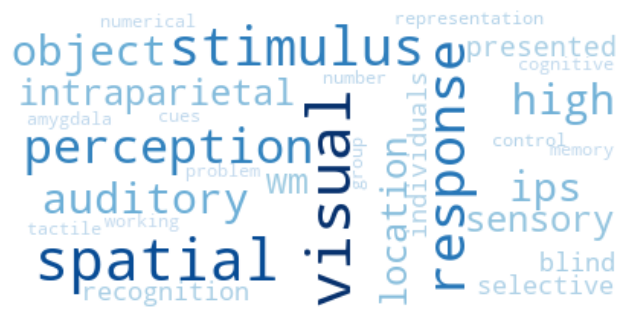

In [69]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_blue_color_func(freqs_color_dict),
                   repeat=False).generate_from_frequencies(freqs_dict )
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
#plt.savefig('./figures/S14b_WordCloud_f2GTf1_TopDegree_NeuosynthDeconding.png')